In [1]:
import numpy as np

## クラスタリングのための人工データセット
クラスタリングを実験するための人工データセットを作成するコードを用意しています。

このmake_blobs関数は正解ラベルも出力してますが、今回は使用しません。使用しないことを明示するために、 **_（アンダースコア）** で受け取っています。

**《シンプルデータセット3》**

In [2]:
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

## 【問題1】中心点の初期値を決める
入力されたデータから $K$ 個の中心点 $\mu_1$ から $\mu_K$ の初期値を決めるコードを作成してください。$K$ は指定したクラスタ数です。

最もシンプルな初期値の決定方法は、データ点 $X_n$ の中からランダムに $K$ 個選ぶことです。今回はこれを実装してください。

K-meansの学習結果は中心点 $\mu$ の初期値に影響を受けます。そのため、学習時には複数個の初期値で計算を行います。

In [3]:
np.random.seed(0)
n_clusters = 3
random_index = np.random.choice(np.arange(X.shape[0]), n_clusters, replace=False)
mu_ = X[random_index]
mu_

array([[-0.565433  ,  3.65813966],
       [ 1.60161834,  0.92363636],
       [ 1.35678894,  4.36462484]])

## 【問題2】SSEを求める関数の作成
クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数を作成してください。

K-meansはこのSSEを最小化する $r_{nk}$ と $\mu_k$ を求めることが目的となります。複数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用します。
$$
SSE = \sum_{n=1}^N \sum_{k=1}^K r_{nk} \|X_n - \mu_k\|^2
$$
$n$ : データ点のインデックス

$k$ : クラスタのインデックス

$X_n$ : $n$番目のデータ点

$\mu_k$ : $k$番目の中心点

$r_{nk}$ : データ点$X_n$がクラスタ$k$に所属していたら1、そうでなければ0

In [4]:
def sum_of_squared_errors(cluster_labels, mu_):
    # 割り当てる変数
    sse = 0
    # ラベル毎にループ（labelは0から）
    for label in range(mu_.shape[0]):
        # ラベルのインデックスを取得
        label_index = np.where(cluster_labels==label)[0]
        # SSEを計算し、割り当て
        sse += np.power(X[label_index] - mu_[label], 2).sum()
    return sse

## クラスタの割り当てと中心点の移動を繰り返す
K-meansの学習の基本は以下の2つのフェーズを繰り返すことです。

中心点 $\mu_k$ を固定した上で $SSE$ を最小化する クラスタの割り当て $r_{nk}$ を選ぶ。
クラスタの割り当て $r_{nk}$ を固定した上で $SSE$ を最小化する 中心点 $\mu_k$ を選ぶ。

最初の中心点 $\mu_k$ は問題1で作成した初期値です。

順番に見ていきます。

## 【問題3】クラスタへの割り当て
全てのデータ点 $X_n$ を最も近い中心点 $\mu_k$ に割り当てるコードを作成してください。

K-menasにおける **近い** とは点と点のユークリッド距離が小さくなることです。ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められるものですが、ベクトル $p,q$ に対しては以下の数式で表現できます。
$$
\|q-p\| = \sqrt{(q-p)\cdot(q-p)}
$$
NumPyにはこの関数が`np.linalg.norm`として用意されているため使用してください。

[numpy.linalg.norm — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html)

中心点 $\mu_k$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

- 計算過程

In [5]:
a = np.random.randint(0, 8, (5, 2))
a

array([[2, 0],
       [5, 3],
       [2, 2],
       [5, 0],
       [7, 5]])

In [6]:
b = np.arange(0, 6).reshape(3, 2)
b

array([[0, 1],
       [2, 3],
       [4, 5]])

In [7]:
b[:, np.newaxis]

array([[[0, 1]],

       [[2, 3]],

       [[4, 5]]])

In [8]:
a - b[:, np.newaxis]

array([[[ 2, -1],
        [ 5,  2],
        [ 2,  1],
        [ 5, -1],
        [ 7,  4]],

       [[ 0, -3],
        [ 3,  0],
        [ 0, -1],
        [ 3, -3],
        [ 5,  2]],

       [[-2, -5],
        [ 1, -2],
        [-2, -3],
        [ 1, -5],
        [ 3,  0]]])

In [9]:
np.linalg.norm(a - b[:, np.newaxis], axis=2)

array([[2.23606798, 5.38516481, 2.23606798, 5.09901951, 8.06225775],
       [3.        , 3.        , 1.        , 4.24264069, 5.38516481],
       [5.38516481, 2.23606798, 3.60555128, 5.09901951, 3.        ]])

In [10]:
np.argmin(np.linalg.norm(a - b[:, np.newaxis], axis=2), axis=0)

array([0, 2, 1, 1, 2])

- Scratchへの実装用

In [11]:
#　mu_　に列を追加して, axis=2でnorm計算
norm = np.linalg.norm(X - mu_[:, np.newaxis], axis=2)
#　最小値を取るインデックスを取得
cluster_labels = np.argmin(norm, axis=0)
cluster_labels

array([2, 0, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 2, 0,
       0, 1, 2, 0, 0, 2, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2,
       0, 0, 1, 2, 0, 1, 2, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0])

## 【問題4】中心点の移動

中心点 $\mu_k$ を $k$ 番目のクラスタに割り当てられる全てのデータ点 $X_n$ の平均値（重心）に移動するコードを作成してください。

クラスタの割り当て $r_{nk}$ を固定した上でSSEを最小化していることになりますが、SSE自体を求める必要はありません。

In [12]:
# ラベル毎にループ（labelは0から）
for label in range(mu_.shape[0]):
    # ラベルのインデックスを取得
    label_index = np.where(cluster_labels==label)[0]
    # 行方向へ平均値を計算して
    mean = X[label_index].mean(axis=0)
    # mu_を更新
    mu_[label] = X[label_index].mean(axis=0)

In [13]:
mu_

array([[-1.34192571,  4.92482991],
       [ 1.99186903,  0.96561071],
       [ 0.62600954,  5.3098476 ]])

## 【問題5】繰り返し
クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成してください。

次のどれかの条件を満たしたらこれを止めます。

- 繰り返しが指定した回数に到達する。（雛形では引数max_iter）
- 中心点 $\mu_k$ と重心の差の合計が指定した許容値以下になる。（雛形では引数tol）

- 下のスクラッチへ実装

## 【問題6】異なる初期値で計算
問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成してください。回数は雛形では引数n_initで指定します。

複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点 $\mu_k$ を保持しておきます。

- 下のスクラッチへ実装

In [14]:
import numpy as np
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    random_state : int
      乱数の設定
    """
    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False, random_state=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        # 乱数のコントロール(int)
        self.random_state = random_state
    
    def _cluster_labels(self, X, mu_):
        #　mu_　に列を追加して, axis=2でnorm計算
        norm = np.linalg.norm(X - mu_[:, np.newaxis], axis=2)
        #　最小値を取るインデックスを取得
        cluster_labels = np.argmin(norm, axis=0)
        return cluster_labels
    
    def _sum_of_squared_errors(self, X, cluster_labels):
        # 割り当てる箱
        sse = 0
        # クラスタ毎にループ
        for cluster in range(self.n_clusters):
            # クラスタのインデックスを取得
            label_index = np.where(cluster_labels==cluster)[0]
            # SSEを計算し、割り当て
            sse += np.power(X[label_index] - self.mu_[cluster], 2).sum()
        return sse
    
    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        """
        # 変数情報を管理
        self.n_samples, self.n_features = X.shape
        # random_stateが設定されている場合はseed設定
        if type(self.random_state) == int:
            np.random.seed(self.random_state)
        #　重心
        self.centroid = None
        # 分類したクラスタの結果
        self.cluster_labels = None
        # sse　の初期値
        self.sse = float('inf')
        
        # 異なる初期値で計算するようにn_init繰り返す
        for init in range(self.n_init):
        
            # mu_を初期化
            random_index = np.random.choice(np.arange(self.n_samples), self.n_clusters, replace=False)
            self.mu_ = X[random_index]
            
            # max_iter回繰り返す
            for iter_ in range(self.max_iter): 

                # mu_に一番近いクラスタの割り当て
                cluster_labels = self._cluster_labels(X, self.mu_)
                
                # cluster_labels内に、n_clusters種類のラベルを持っていない場合はエラー対応
                if np.unique(cluster_labels).shape[0] != self.n_clusters:
                    # mu_を初期化
                    random_index = np.random.choice(np.arange(self.n_samples), self.n_clusters, replace=False)
                    self.mu_ = X[random_index]
                    
                    # mu_に一番近いクラスタの割り当て
                    cluster_labels = self._cluster_labels(X, self.mu_)

                # 中心点を移動させる
                #　新たな中心点（重心）を格納する
                new_mu_ = np.zeros(self.n_features * self.n_clusters).reshape(self.n_clusters, -1)
                # クラスタ毎にループ
                for cluster in range(self.n_clusters):
                    # クラスタのインデックスを取得
                    cluster_index = np.where(cluster_labels==cluster)[0]
                    # 行方向へ平均値を計算して、new_mu_へ代入
                    new_mu_[cluster] = X[cluster_index].mean(axis=0)

                # 中心点と重心の差の和を計算
                error = np.power(self.mu_ - new_mu_, 2).sum()
                # mu_を重心へ更新
                self.mu_ = new_mu_
                # errorが許容値以下なら繰り返し終了
                if error <= self.tol:
                    break
                    
            # init　が終わったらSSEを計算し、最小の場合はmu_を保管
            sse_calc = self._sum_of_squared_errors(X, cluster_labels)            
            if self.sse > sse_calc:
                self.centroid = self.mu_
                self.cluster_labels = cluster_labels
                self.sse = sse_calc

            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print('n_init : {}　回目'.format(init + 1))
                print('{} 回、中心を移動させました'.format(iter_ + 1))
                print('移動後の中心 :\n{}'.format(self.mu_))
                print('SSE : {}'.format(sse_calc))
                print('移動後のクラスタ　:\n{}'.format(cluster_labels))
                print()

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        """
        if self.centroid is None:
            print("It hasn't fitted yet.")
        else:
            return self._cluster_labels(X, self.centroid)

- scratchとsklearnの計算を比較

In [15]:
scratch = ScratchKMeans(n_clusters=3, n_init=10, max_iter=300,
                         tol=1e-4, verbose=True, random_state=0)
scratch.fit(X)

n_init : 1　回目
7 回、中心を移動させました
移動後の中心 :
[[-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]
 [-0.27678616  3.72096344]]
SSE : 139.17097772033804
移動後のクラスタ　:
[2 0 2 2 2 2 2 0 2 0 0 0 0 0 0 1 1 2 2 1 2 0 2 1 2 2 2 2 1 1 1 0 1 1 2 2 0
 1 0 2 2 2 0 2 2 0 1 2 2 2 2 1 2 2 2 0 0 1 1 0 0 1 1 2 1 0 2 2 1 2 0 1 2 0
 2 2 2 2 1 1 1 0 2 2 1 2 1 1 2 2 2 2 2 2 2 0 0 2 0 2]

n_init : 2　回目
5 回、中心を移動させました
移動後の中心 :
[[-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]
 [-0.27678616  3.72096344]]
SSE : 139.17097772033804
移動後のクラスタ　:
[2 0 2 2 2 2 2 0 2 0 0 0 0 0 0 1 1 2 2 1 2 0 2 1 2 2 2 2 1 1 1 0 1 1 2 2 0
 1 0 2 2 2 0 2 2 0 1 2 2 2 2 1 2 2 2 0 0 1 1 0 0 1 1 2 1 0 2 2 1 2 0 1 2 0
 2 2 2 2 1 1 1 0 2 2 1 2 1 1 2 2 2 2 2 2 2 0 0 2 0 2]

n_init : 3　回目
5 回、中心を移動させました
移動後の中心 :
[[-0.27678616  3.72096344]
 [-1.26811733  7.76378266]
 [ 1.99186903  0.96561071]]
SSE : 139.17097772033804
移動後のクラスタ　:
[0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 2 2 0 0 2 0 1 0 2 0 0 0 0 2 2 2 1 2 2 0 0 1
 2 1 0 0 0 1 0 0 1 2 0 0 0 0 2 0 0 0 1 1 2 2 1 

In [16]:
scratch.centroid, scratch.cluster_labels

(array([[-1.26811733,  7.76378266],
        [ 1.99186903,  0.96561071],
        [-0.27678616,  3.72096344]]),
 array([2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0,
        2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 0, 2,
        2, 0, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0,
        2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 2, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2]))

In [17]:
from sklearn.cluster import k_means
cetroid, label, inertia, best_n_iter = k_means(X, n_clusters=3, random_state=0, return_n_iter=True)
cetroid, label, inertia, best_n_iter

(array([[-0.27678616,  3.72096344],
        [-1.26811733,  7.76378266],
        [ 1.99186903,  0.96561071]]),
 array([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 0, 1,
        0, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0,
        0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1,
        0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], dtype=int32),
 139.17097772033804,
 3)

- n_clusters : 10 までsklearnと比較

In [18]:
for n_clusters in range(2, 11):
    print('n_clusters : {}'.format(n_clusters))
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                         tol=1e-4, verbose=False, random_state=0)
    scratch.fit(X)
    print('scratch_centroid :')
    scratch_sort = np.sort(scratch.centroid, axis=0)
    print(scratch_sort)
    from sklearn.cluster import k_means
    cetroid, label, inertia, best_n_iter = k_means(X, n_clusters=n_clusters, random_state=0, return_n_iter=True)
    print('sklearn_centroid :')
    sklearn_sort = np.sort(cetroid, axis=0)
    print(sklearn_sort)
    print('isclose_atol = 1e-1 :')
    print(np.isclose(scratch_sort, sklearn_sort ,atol=1e-1))
    print()

n_clusters : 2
scratch_centroid :
[[-1.26811733  2.80251253]
 [ 0.47943223  7.76378266]]
sklearn_centroid :
[[-1.26811733  2.80251253]
 [ 0.47943223  7.76378266]]
isclose_atol = 1e-1 :
[[ True  True]
 [ True  True]]

n_clusters : 3
scratch_centroid :
[[-1.26811733  0.96561071]
 [-0.27678616  3.72096344]
 [ 1.99186903  7.76378266]]
sklearn_centroid :
[[-1.26811733  0.96561071]
 [-0.27678616  3.72096344]
 [ 1.99186903  7.76378266]]
isclose_atol = 1e-1 :
[[ True  True]
 [ True  True]
 [ True  True]]

n_clusters : 4
scratch_centroid :
[[-1.47935679  0.96561071]
 [-1.26811733  3.11716896]
 [ 0.92578447  4.32475792]
 [ 1.99186903  7.76378266]]
sklearn_centroid :
[[-1.47935679  0.96561071]
 [-1.26811733  3.11716896]
 [ 0.92578447  4.32475792]
 [ 1.99186903  7.76378266]]
isclose_atol = 1e-1 :
[[ True  True]
 [ True  True]
 [ True  True]
 [ True  True]]

n_clusters : 5
scratch_centroid :
[[-1.47935679  0.55246837]
 [-1.26811733  1.41318158]
 [ 0.92578447  3.11716896]
 [ 1.82902257  4.32475792]


- n_clusters : 4　までは、sklearnと同様の動き
- n_clusters : 5　以降も多少の誤差はあるが凡そ正しく実装できていると思われる

## 【問題7】推定

新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行います。

- データ点 $X_n$ と学習で決まった中心点 $\mu_k$ に対し、 $SSE$ を最小化する $r_{nk}$ を選ぶ。

具体的には次のことです。

- データ点 $X_n$ を最も近い $\mu_k$ に割り当てる。

- 上のスクラッチへ実装

In [19]:
X_2, _ = make_blobs(n_samples=20, n_features=2, centers=4,cluster_std=0.5, shuffle=True, random_state=100)
scratch.predict(X_2)

array([2, 3, 2, 3, 8, 2, 8, 1, 3, 1, 1, 7, 2, 1, 2, 8, 3, 1, 8, 8])

## 【問題8】エルボー法の実装
K-meansにおいて中心点の個数 $k$ は人為的に決める必要がありますが、その判断方法としてエルボー法があります。エルボー法により中心点の個数 $k$ を検討するためのコードを作成してください。

SSEを縦軸、クラスタ数 $k$ を横軸にした折れ線グラフを表示します。このためにK-meansのインスタンスからはSSEを取得できるようにしてください。

In [20]:
def elbow_method(X, max_clusters):
    sse_array = np.zeros(max_clusters-1)
    for clusters in range(2, max_clusters+1):
        scratch = ScratchKMeans(n_clusters=clusters, n_init=10, max_iter=300,
                         tol=1e-4, random_state=0)
        scratch.fit(X)
        sse_array[clusters-2] = scratch.sse
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.plot(np.arange(2, max_clusters+1), sse_array, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('SSE')
    plt.show()

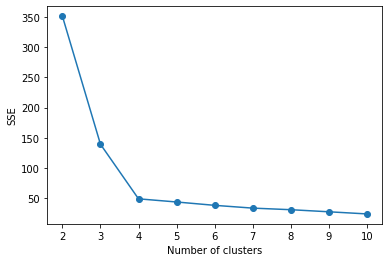

In [21]:
elbow_method(X, max_clusters=10)

## 【問題9】（アドバンス課題）シルエット図
$k$ を決める助けになるものとしてシルエット図もあります。シルエット図を表示するコードを作成してください。

Matplotlibを使い図を表示するコードは用意しました。以下を与えてください。

`silhouette_vals` : shape(n_samples,)のndarray、各データ点のシルエット係数

`silhouette_avg` : float、シルエット係数の平均値

`y_km` : shape(n_samples,)のndarray、各データ点のクラスタラベル名

`cluster_labels` : list、クラスタのラベル名のリスト

`n_clusters` : int、クラスタ数

$n$ 番目のデータ点に対するシルエット係数 $s_n$ は以下の数式でを求められます。この数式を実装し、シルエット図を確認してください。
$$
s_n = \frac{b_n-a_n}{max(b_n,a_n)}
$$

$a_n$ : 凝集度。同じクラスタ内の他のデータ点との距離の平均値。

$b_n$ : 乖離度。最も近い他のクラスタ内の全てのデータ点との距離の平均値。

乖離度 $b$ が大きく、凝集度 $a$ が小さい時が理想的であり、シルエット係数 $s$ は1に近くなります。

In [22]:
def silhouette(X, n_clusters):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                             tol=1e-4, random_state=0)
    scratch.fit(X)
    
    y_km = scratch.cluster_labels
    # X = X[np.argsort(scratch.cluster_labels)]
    unique, unique_count = np.unique(y_km, return_counts=True)
    # シルエット係数
    silhouette_vals = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        # データ点とクラスタの距離を計算
        norm_clusters = np.linalg.norm(X[i] - scratch.centroid, axis=1)
        # print(norm_clusters)
        # print(y_km[i])
        
        #二番目に近いクラスタを選択（nearest_clustersが1のインデックスを取得）
        nearest_cluster = np.where(np.argsort(norm_clusters) == 1)[0]
        # print(nearest_cluster)
        
        # a, b を計算し、シルエット係数を求める
        a = np.sum(np.linalg.norm(X[i] - X[np.where(y_km == y_km[i])[0]], axis=1)) / (unique_count[y_km[i]] - 1)
        # a = np.linalg.norm(X[i] - X[np.where(y_km == y_km[i])[0]]) / (unique_count[y_km[i]] - 1)
        b = np.linalg.norm(X[i] - X[np.where(y_km == nearest_cluster)[0]], axis=1).mean()
        silhouette_vals[i] = (b-a) / max(a, b)
            
    # シルエット係数、クラスタラベルの順でソート
    # silhouette_vals = silhouette_vals[np.lexsort((-silhouette_vals, y_km))]
    # y_km　を並び替え
    # y_km = sorted(y_km)
    silhouette_avg = silhouette_vals.mean()
    cluster_labels = unique
    
    from matplotlib import cm
    import matplotlib.pyplot as plt
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        # print(c_silhouette_vals)
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

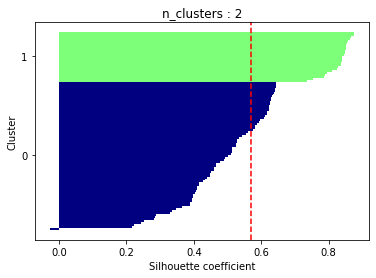

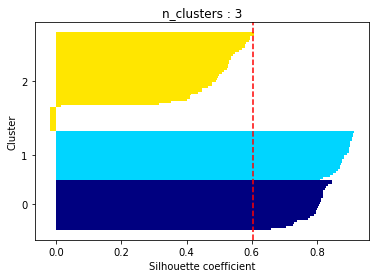

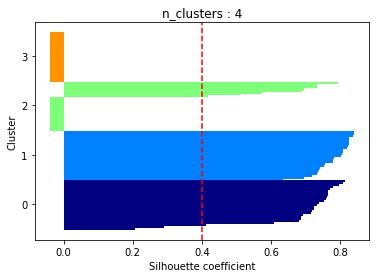

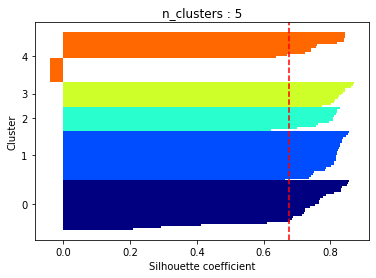

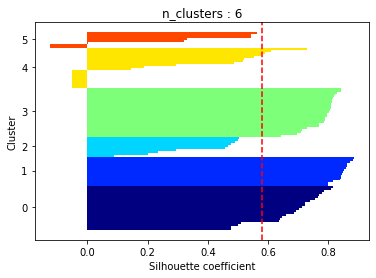

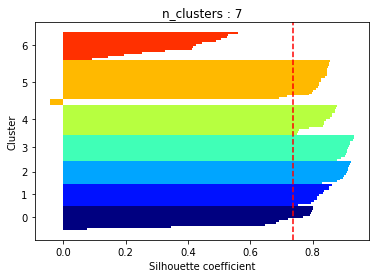

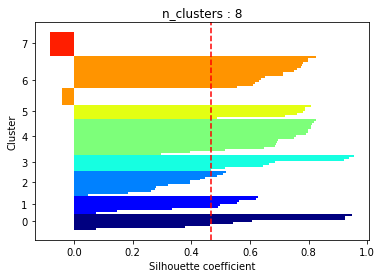

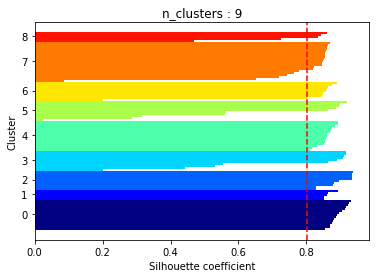

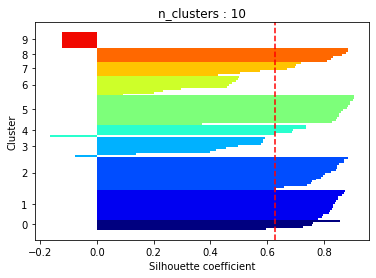

In [23]:
for n_clusters in range(2, 11):
    silhouette(X, n_clusters)

- sklearnのものでも図示してみる

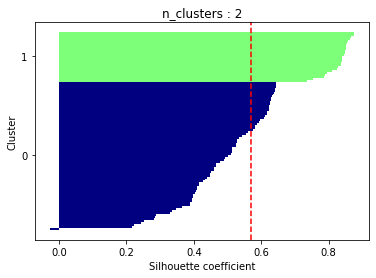

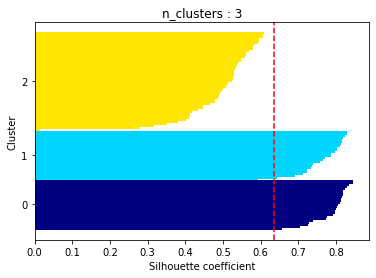

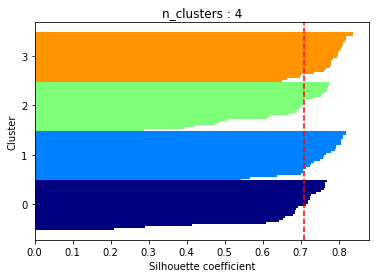

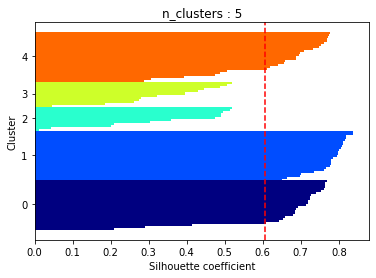

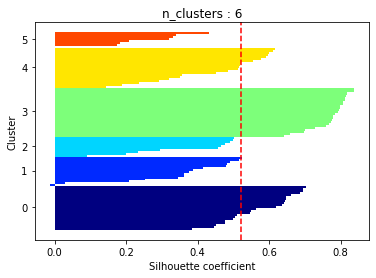

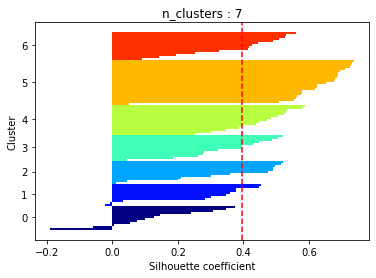

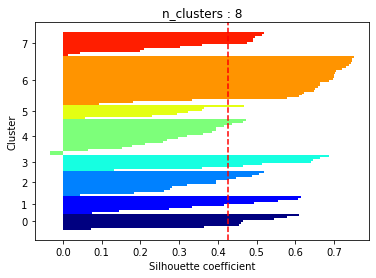

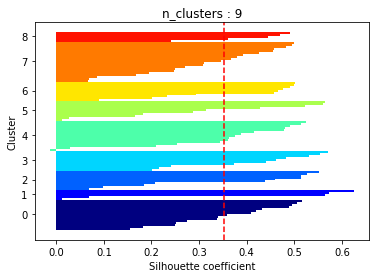

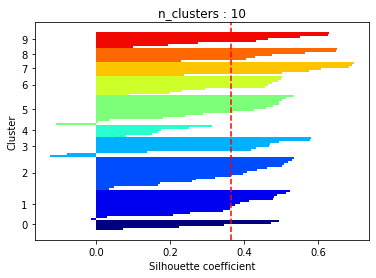

In [24]:
# sklearn　シルエット係数を計算
for n_clusters in range(2, 11):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                             tol=1e-4, random_state=0)
    scratch.fit(X)
    
    y_km = scratch.cluster_labels

    from sklearn.metrics import silhouette_samples
    from matplotlib import cm
    import matplotlib.pyplot as plt

    cluster_labels = np.unique(y_km)       # y_kmの要素の中で重複を無くす
    n_clusters=cluster_labels.shape[0]     # 配列の長さを返す。つまりここでは n_clustersで指定した3となる

    # シルエット係数を計算
    silhouette_vals = silhouette_samples(X,y_km,metric='euclidean')  # サンプルデータ, クラスター番号、ユークリッド距離でシルエット係数計算
    silhouette_avg = np.mean(silhouette_vals)

    from matplotlib import cm
    import matplotlib.pyplot as plt
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

- sklearnと比較すると、凡その動きは一緒であるが、scratchで一部うまく計算できていないところがある
- 原因を確認

In [25]:
def silhouette_debug(X, n_clusters):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                             tol=1e-4, random_state=0)
    scratch.fit(X)
    
    y_km = scratch.cluster_labels
    # X = X[np.argsort(scratch.cluster_labels)]
    unique, unique_count = np.unique(y_km, return_counts=True)
    # シルエット係数
    silhouette_vals = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        # データ点とクラスタの距離を計算
        norm_clusters = np.linalg.norm(X[i] - scratch.centroid, axis=1)
        # print(norm_clusters)
        # print(y_km[i])
        
        #二番目に近いクラスタを選択（nearest_clustersが1のインデックスを取得）
        nearest_cluster = np.where(np.argsort(norm_clusters) == 1)[0]
        # print(nearest_cluster)
        
        # a, b を計算し、シルエット係数を求める
        a = np.sum(np.linalg.norm(X[i] - X[np.where(y_km == y_km[i])[0]], axis=1)) / (unique_count[y_km[i]] - 1)
        # a = np.linalg.norm(X[i] - X[np.where(y_km == y_km[i])[0]]) / (unique_count[y_km[i]] - 1)
        b = np.linalg.norm(X[i] - X[np.where(y_km == nearest_cluster)[0]], axis=1).mean()
        silhouette_vals[i] = (b-a) / max(a, b)
        if y_km[i] == nearest_cluster:
            print('NGNGNGNG')
            print('cluster : {}'.format(y_km[i]))
            print('nearest_cluster : {}'.format(nearest_cluster))
            print('norm_clusters')
            print('重心の距離 {}'.format(norm_clusters))
            print('np.argsort(norm_clusters)')
            print('距離の順位 {}'.format(np.argsort(norm_clusters)))
            print()
            
    # シルエット係数、クラスタラベルの順でソート
    # silhouette_vals = silhouette_vals[np.lexsort((-silhouette_vals, y_km))]
    # y_km　を並び替え
    # y_km = sorted(y_km)
    silhouette_avg = silhouette_vals.mean()
    cluster_labels = unique
    
    from matplotlib import cm
    import matplotlib.pyplot as plt
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        # print(c_silhouette_vals)
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

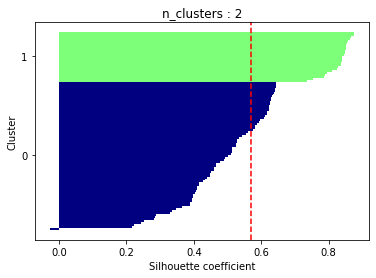

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.95147123 4.90408662 1.68758551]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [2.84760567 4.70095778 1.60871385]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.7280392  3.82279173 1.11854734]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.5824946  4.1733812  1.86328437]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [4.3466355  4.70171285 1.72396551]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.47137843 4.07260347 1.15613468]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.95009735 4.71559999 1.47271928]
np.argsort(norm_clusters)
距離の順位 [2 0 1]

NGNGNGNG
cluster : 2
neares

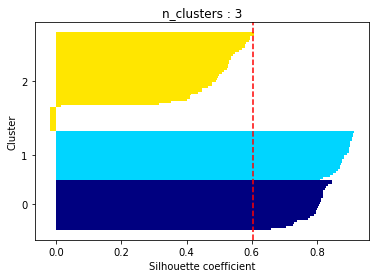

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [2.2795972  3.02757037 0.64471883 4.51232571]
np.argsort(norm_clusters)
距離の順位 [2 0 1 3]

NGNGNGNG
cluster : 3
nearest_cluster : [3]
norm_clusters
重心の距離 [4.86956057 8.00952895 4.60819248 0.65931349]
np.argsort(norm_clusters)
距離の順位 [3 2 0 1]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.0983655  3.45783512 0.43284435 4.29469519]
np.argsort(norm_clusters)
距離の順位 [2 0 1 3]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [2.88255928 3.64988042 0.21126946 4.01122399]
np.argsort(norm_clusters)
距離の順位 [2 0 1 3]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [3.55329431 3.95966815 0.88301701 4.04347571]
np.argsort(norm_clusters)
距離の順位 [2 0 1 3]

NGNGNGNG
cluster : 2
nearest_cluster : [2]
norm_clusters
重心の距離 [2.48770388 3.40873075 0.22388804 4.15281223]
np.argsort(norm_clusters)
距離の順位 [2 0 1 3]

NGNGNGNG
cluster : 3
nearest_cluster : [3]
norm_clusters
重心の距離 [4.81408857 7.44618872 3.

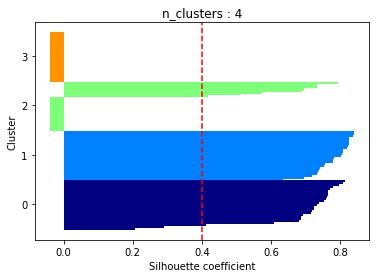

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.2795972  4.51232571 2.55329985 3.46584671 0.64471883]
np.argsort(norm_clusters)
距離の順位 [4 0 2 3 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [3.0983655  4.29469519 2.98898342 3.89222172 0.43284435]
np.argsort(norm_clusters)
距離の順位 [4 2 0 3 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.48770388 4.15281223 2.93250686 3.84833345 0.22388804]
np.argsort(norm_clusters)
距離の順位 [4 0 2 3 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [3.61977918 5.38069615 2.18174084 3.02429543 1.40171995]
np.argsort(norm_clusters)
距離の順位 [4 2 3 0 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.72035494 4.5687556  2.56004645 3.47413819 0.49353581]
np.argsort(norm_clusters)
距離の順位 [4 2 0 3 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.40410846 4.18253921 2.89205966 3.80729966 0.31521223]
np.argsort(norm_clusters)
距離の順位 [4 0 2 3 1]

NGNGNGNG
c

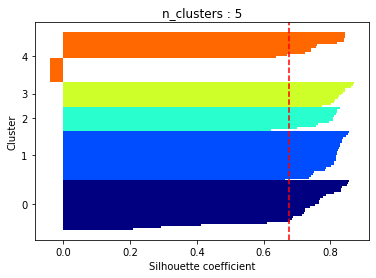

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [3.24041878 3.82481328 2.90860959 4.29469519 0.28667551 1.48729204]
np.argsort(norm_clusters)
距離の順位 [4 5 2 0 1 3]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.62961187 3.77785985 2.85526201 4.15281223 0.40798771 0.87893627]
np.argsort(norm_clusters)
距離の順位 [4 5 0 2 1 3]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.8624241  3.4047428  2.48102673 4.5687556  0.55941591 1.13185143]
np.argsort(norm_clusters)
距離の順位 [4 5 2 0 1 3]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.54616694 3.73654776 2.81550859 4.18253921 0.49913488 0.79338888]
np.argsort(norm_clusters)
距離の順位 [4 5 0 2 1 3]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [3.14156783 3.96206689 3.04185106 4.11431892 0.12530886 1.39824063]
np.argsort(norm_clusters)
距離の順位 [4 5 2 0 1 3]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.8508652  3.76261954 2.83872193 4.21526755 0.

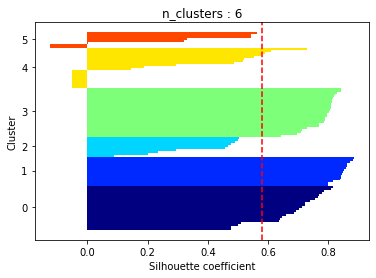

NGNGNGNG
cluster : 5
nearest_cluster : [5]
norm_clusters
重心の距離 [2.3332026  4.82822453 4.3348298  5.05659006 3.38216671 0.57228679
 3.97092949]
np.argsort(norm_clusters)
距離の順位 [5 0 4 6 2 1 3]

NGNGNGNG
cluster : 5
nearest_cluster : [5]
norm_clusters
重心の距離 [2.02587554 4.42627827 4.3210627  5.09220992 3.06612364 0.7807478
 3.57995008]
np.argsort(norm_clusters)
距離の順位 [5 0 4 6 2 1 3]

NGNGNGNG
cluster : 5
nearest_cluster : [5]
norm_clusters
重心の距離 [1.85477869 4.46921205 4.13140402 4.90872944 2.899729   0.69281665
 3.63647554]
np.argsort(norm_clusters)
距離の順位 [5 0 4 6 2 1 3]



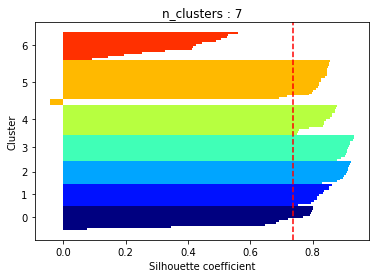

NGNGNGNG
cluster : 7
nearest_cluster : [7]
norm_clusters
重心の距離 [5.9854277  6.97820888 1.47921732 6.51397714 2.57134306 2.48909842
 3.2012209  0.58140448]
np.argsort(norm_clusters)
距離の順位 [7 2 5 4 6 0 3 1]

NGNGNGNG
cluster : 6
nearest_cluster : [6]
norm_clusters
重心の距離 [4.2482341  5.16353604 4.66056233 5.19914351 2.88265845 3.73552047
 0.42618024 3.99389636]
np.argsort(norm_clusters)
距離の順位 [6 4 5 7 0 2 1 3]

NGNGNGNG
cluster : 6
nearest_cluster : [6]
norm_clusters
重心の距離 [4.00297007 4.91195901 4.83515837 4.96325477 2.81400476 3.69181461
 0.43818742 4.14034394]
np.argsort(norm_clusters)
距離の順位 [6 4 5 0 7 2 1 3]

NGNGNGNG
cluster : 7
nearest_cluster : [7]
norm_clusters
重心の距離 [6.73391638 7.69141071 1.45056157 7.09348589 3.26073492 2.78603742
 4.46369485 1.06236189]
np.argsort(norm_clusters)
距離の順位 [7 2 5 4 6 0 3 1]

NGNGNGNG
cluster : 7
nearest_cluster : [7]
norm_clusters
重心の距離 [6.35209346 7.33259647 1.24082127 6.80774014 2.8813507  2.60774903
 3.78027755 0.44275699]
np.argsort(norm_clusters)


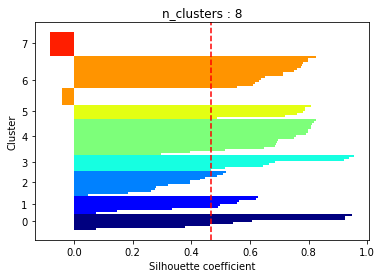

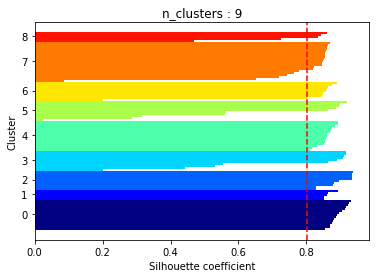

NGNGNGNG
cluster : 9
nearest_cluster : [9]
norm_clusters
重心の距離 [4.40848344 8.37230464 4.47963885 0.93598697 5.21806761 4.66172512
 7.46661923 1.19524446 5.44527443 0.24779439]
np.argsort(norm_clusters)
距離の順位 [9 3 7 0 2 5 4 8 6 1]

NGNGNGNG
cluster : 4
nearest_cluster : [4]
norm_clusters
重心の距離 [2.45133622 2.96298619 1.47830861 5.01048962 1.05547991 3.85981345
 2.10287999 5.30759522 3.6026291  5.95753813]
np.argsort(norm_clusters)
距離の順位 [4 2 6 0 1 8 5 3 7 9]

NGNGNGNG
cluster : 9
nearest_cluster : [9]
norm_clusters
重心の距離 [4.05367132 8.02863338 4.16699404 0.63872895 4.88839553 4.30749502
 7.12566498 1.20848217 5.08741663 0.53542075]
np.argsort(norm_clusters)
距離の順位 [9 3 7 0 2 5 4 8 6 1]

NGNGNGNG
cluster : 9
nearest_cluster : [9]
norm_clusters
重心の距離 [5.08769503 8.94392597 4.93047325 1.56914405 5.73407799 5.49571794
 8.02557064 1.07399714 6.25037253 0.69431536]
np.argsort(norm_clusters)
距離の順位 [9 7 3 2 0 5 4 8 6 1]

NGNGNGNG
cluster : 9
nearest_cluster : [9]
norm_clusters
重心の距離 [4.66814927 8

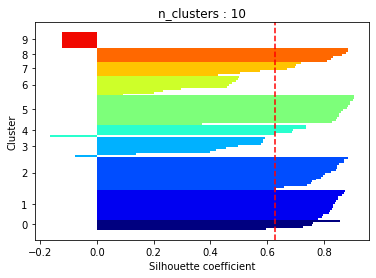

In [26]:
for n_clusters in range(2, 11):
    silhouette_debug(X, n_clusters)

- グラフが正しく表示されていない部分について、データ点のクラスタとそのクラスタから最も近い他のクラスタが同じクラスタになってしまっている
- numpy.argsort　が正しく計算できていないと思われる

In [27]:
# バグとなったデータで出力
print('np.argsort([3.95147123, 4.90408662, 1.68758551])')
print('欲しい出力 >> \narray[1, 2, 0]')
print('実際の出力　>> ')
np.argsort([3.95147123, 4.90408662, 1.68758551])

np.argsort([3.95147123, 4.90408662, 1.68758551])
欲しい出力 >> 
array[1, 2, 0]
実際の出力　>> 


array([2, 0, 1])

In [28]:
print('np.argsort([3, 1, 2])')
print('欲しい出力 >> \narray[2, 0, 1]')
print('実際の出力　>> ')
np.argsort([3, 1, 2])

np.argsort([3, 1, 2])
欲しい出力 >> 
array[2, 0, 1]
実際の出力　>> 


array([1, 2, 0])

- numpy.argsortを二重にかけると回避できるらしい

In [29]:
np.argsort(np.argsort([3.95147123, 4.90408662, 1.68758551]))

array([1, 2, 0])

In [30]:
np.argsort(np.argsort([3, 1, 2]))

array([2, 0, 1])

- scratchしていた関数を修正する

In [31]:
def silhouette_fix(X, n_clusters):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                             tol=1e-4, random_state=0)
    scratch.fit(X)
    
    y_km = scratch.cluster_labels
    unique, unique_count = np.unique(y_km, return_counts=True)
    # シルエット係数
    silhouette_vals = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        # データ点とクラスタの距離を計算
        norm_clusters = np.linalg.norm(X[i] - scratch.centroid, axis=1)
        
        #二番目に近いクラスタを選択
        #norm_clustersの最小インデックスを取得して、要素をinfに置き換える
        min_index = np.argmin(norm_clusters)
        norm_clusters[min_index] = float('inf')
        # 最小インデックスが求めるクラスタ
        nearest_cluster = np.argmin(norm_clusters)
        
        # a, b を計算し、シルエット係数を求める
        a = np.sum(np.linalg.norm(X[i] - X[np.where(y_km == y_km[i])[0]], axis=1)) / (unique_count[y_km[i]] - 1)
        b = np.linalg.norm(X[i] - X[np.where(y_km == nearest_cluster)[0]], axis=1).mean()
        silhouette_vals[i] = (b-a) / max(a, b)

    silhouette_avg = silhouette_vals.mean()
    cluster_labels = unique
    
    from matplotlib import cm
    import matplotlib.pyplot as plt
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

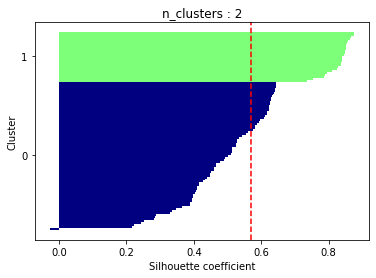

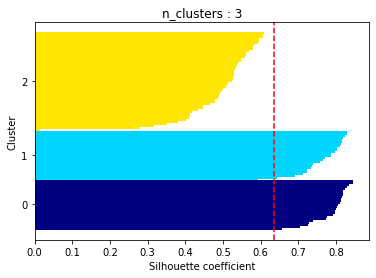

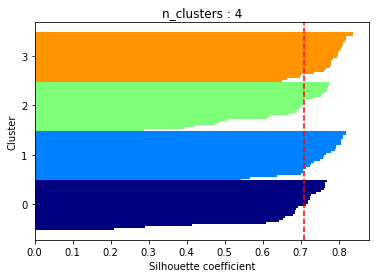

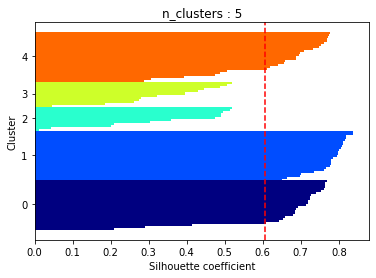

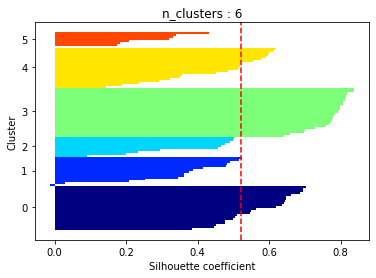

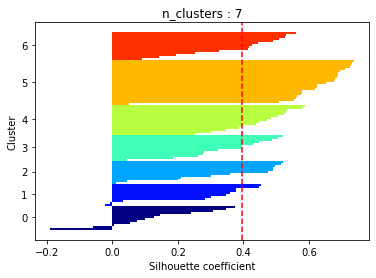

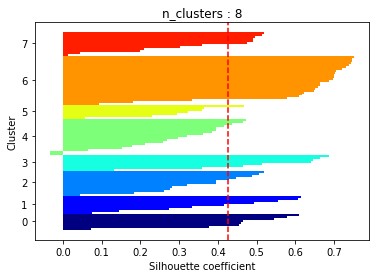

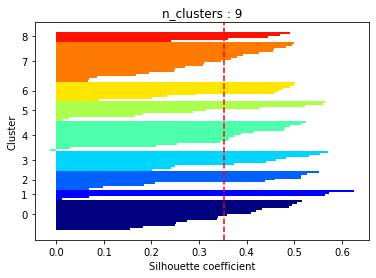

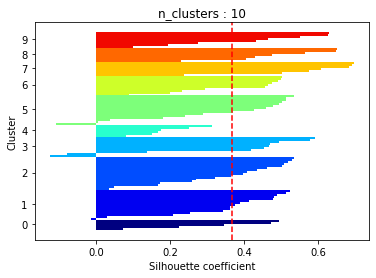

In [32]:
for n_clusters in range(2, 11):
    silhouette_fix(X, n_clusters)

- 正しく実装できていると思われる

## クラスタ分析

## 卸売業者のデータ分析

クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

[UCI Machine Learning Repository: Wholesale customers Data Set](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers)

Data Folderの中から'Wholesale customers data.csv'をダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。`Region`と`Channel`は取り覗き、金額のデータでK-meansを利用します

In [33]:
import pandas as pd
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
df = pd.read_csv(url)
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [34]:
# df　に購入金額の合計を追加
df = pd.concat([df, pd.DataFrame(df.iloc[:, 2:].sum(axis=1), columns=['Total'])], axis=1)

In [35]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455,33226.136364
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937,26356.301730
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,904.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000,17448.750000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000,27492.000000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000,41307.500000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000,199891.000000


## 次元削減

金額に関する特徴量は6個ありますが、可視化するために次元削減を行います。これに関してはscikit-learnによるPCAのサンプルコードを用意したので利用してください。

In [36]:
data = df.iloc[:, 2:-1].values

**《PCAのサンプルコード》**

In [37]:
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)

**《PCAの分散説明率を表示するコードサンプル》**

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


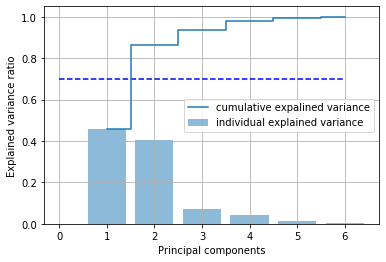

In [38]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

## 【問題10】クラスタ数kの選択
最適だと思われるクラスタ数 $k$ を選択してください。エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってきます。選択した上で、なぜそれを選んだか説明してください。

- PCAの分解説明率の可視化において、2次元にて86%を説明しているので、データ可視化のために、2次元まで次元削減してクラスタ数の検討を行う

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
# ２次元まで削減したデータ
data_pca = pca.transform(data)

- エルボー法

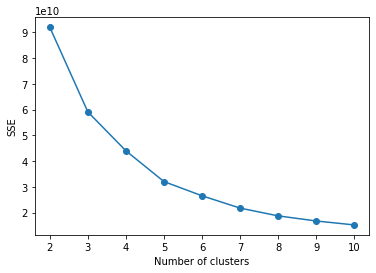

In [40]:
elbow_method(data_pca, max_clusters=10)

- シルエット図

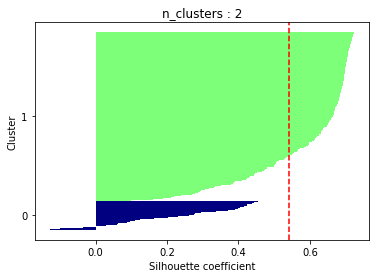

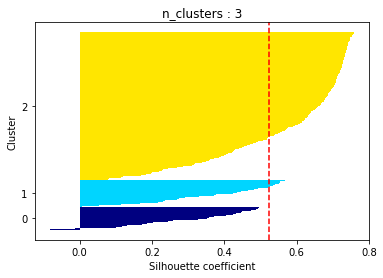

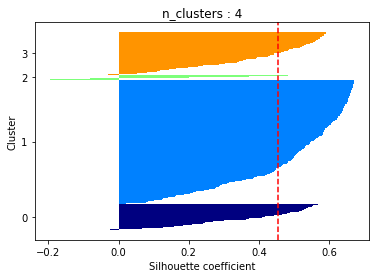

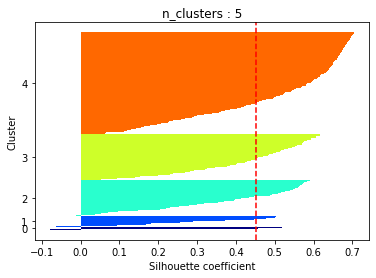

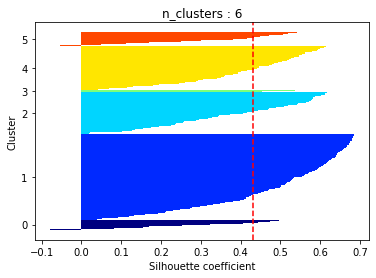

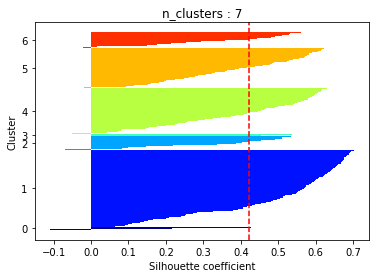

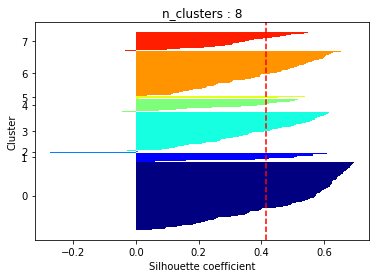

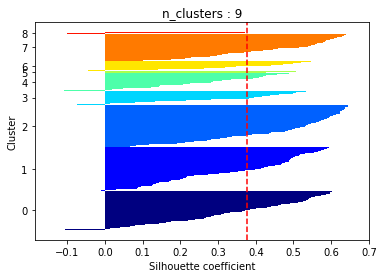

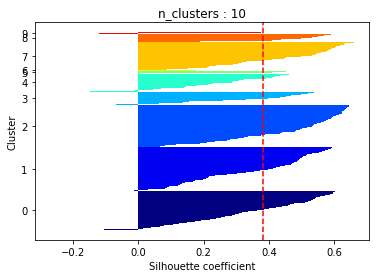

In [41]:
for n_clusters in range(2, 11):
    silhouette_fix(data_pca, n_clusters)

- クラスタ数毎の分布をみる

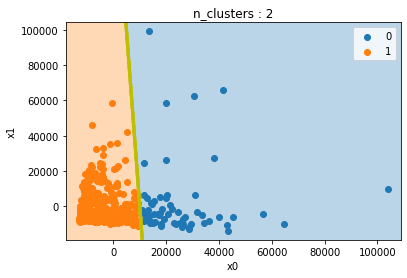

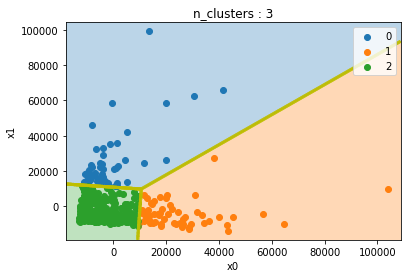

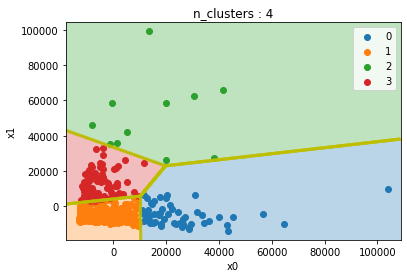

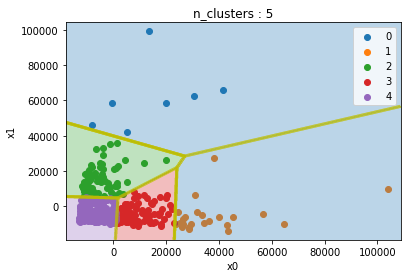

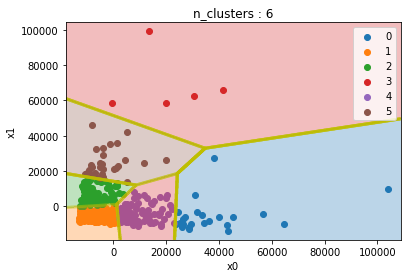

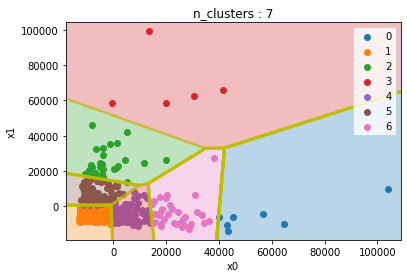

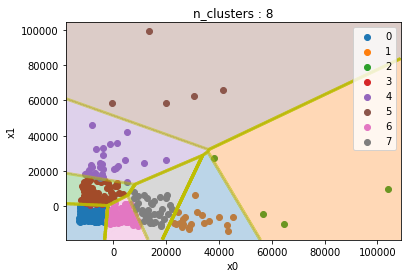

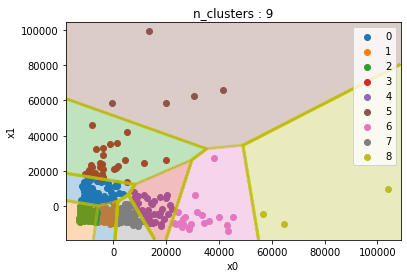

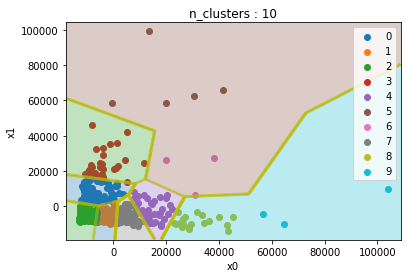

In [42]:
# 領域の図
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(data_pca[:,0])-5000,
                                          np.max(data_pca[:,0])+5000, 100),
                                np.arange(np.min(data_pca[:,1])-5000,
                                          np.max(data_pca[:,1])+5000, 100))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

for n_clusters in range(2, 11):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                         tol=1e-4, verbose=False, random_state=0)
    scratch.fit(data_pca)
    mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
    for i in range(n_clusters):
        plot_index = np.where(scratch.cluster_labels == i)[0]
        plt.scatter(data_pca[plot_index, 0], data_pca[plot_index, 1], label=i)
    plt.contourf(mesh_f0, mesh_f1, mesh_pred, alpha=0.3,  cmap=ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_clusters]))
    plt.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.legend()
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

- エルボー法、シルエット法の２つの手法において、クラスタ分類数を決める決定的な情報は得られなかった
- クラスタ数毎にプロットした図を見てみると、n_clusters : 3 の時、label:0 及び label:2　は次元削減後の特徴量において、そのどちらかが約10,000を超えたものの集まりであり、label:1　はどちらも約10,000未満の集まりとなっている
- 卸売業者にとって、顧客単価の高低がわかるので、クラスタ数kを、3に設定する

## 【問題11】既知のグループとの比較
RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループです。クラスタとこれら既知のグループがどう違うかを確認し、説明してください。まずはそれぞれを可視化してください。

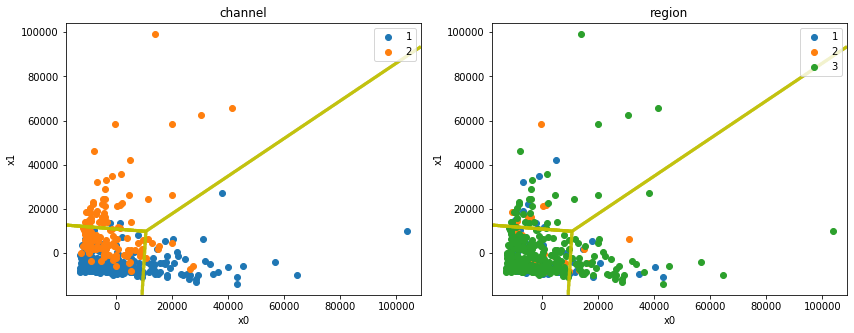

In [43]:
channel = df.iloc[:, 0].values
region = df.iloc[:, 1].values
group_label = [channel, region]
title = ['channel', 'region']
fig = plt.figure(figsize=(14, 5))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    # 既知のグループをプロット
    for label in np.unique(group_label[i]):
        label_index = np.where(group_label[i] == label)[0]
        ax.scatter(data_pca[label_index, 0], data_pca[label_index, 1], label=label)
    
    # クラスタk = 3の分布を表示
    scratch = ScratchKMeans(n_clusters=3, n_init=10, max_iter=300,
                         tol=1e-4, verbose=False, random_state=0)
    scratch.fit(data_pca)
    mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
    # plt.contourf(mesh_f0, mesh_f1, mesh_pred, alpha=0.3,  cmap=ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_clusters]))
    ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    ax.legend()
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(title[i])
plt.show()

- channel での分類は、　x1　の高低で分割されている傾向が見て取れるため、cluster:3　の分類と傾向としては似通っている
- region での分類は、x0, x1　に相関なく満遍なく分布している

- クラスタ数を変更させて分布を見てみる

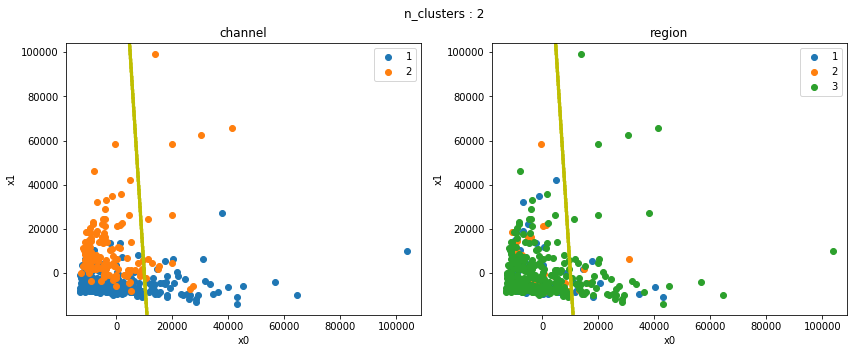

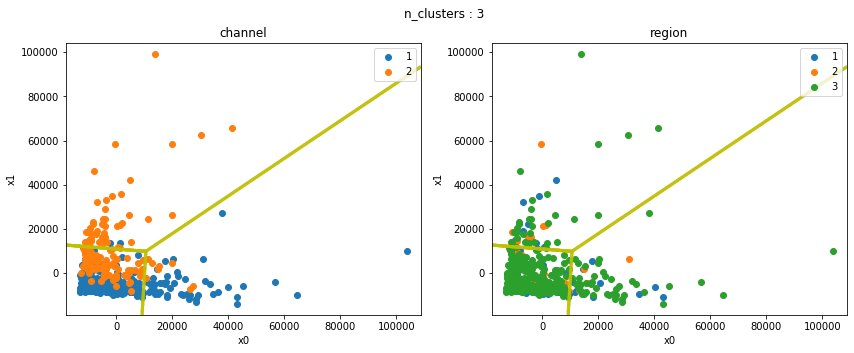

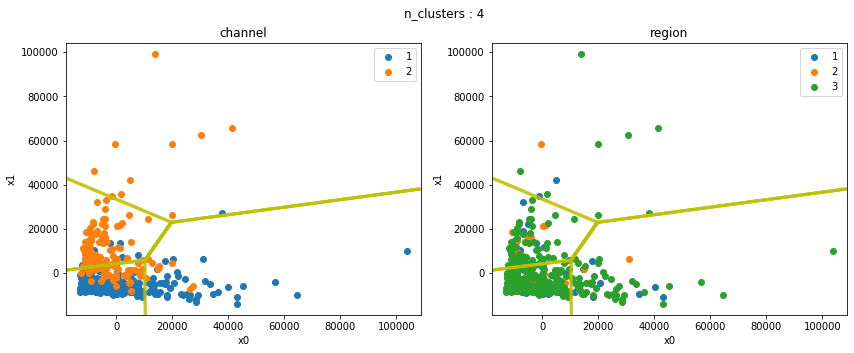

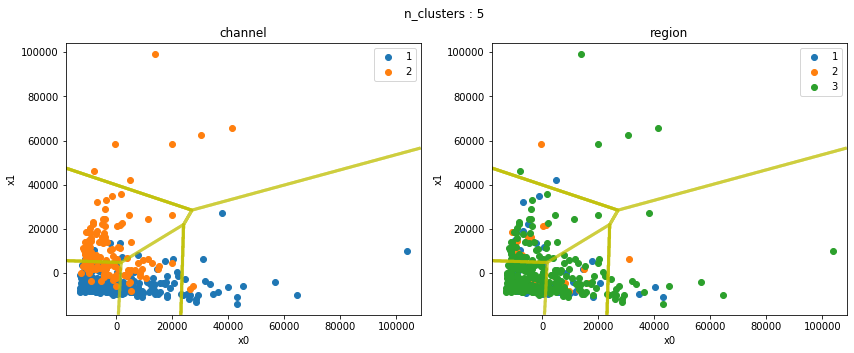

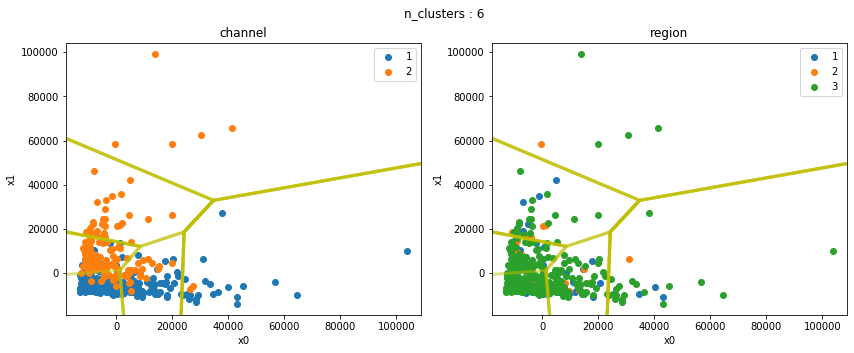

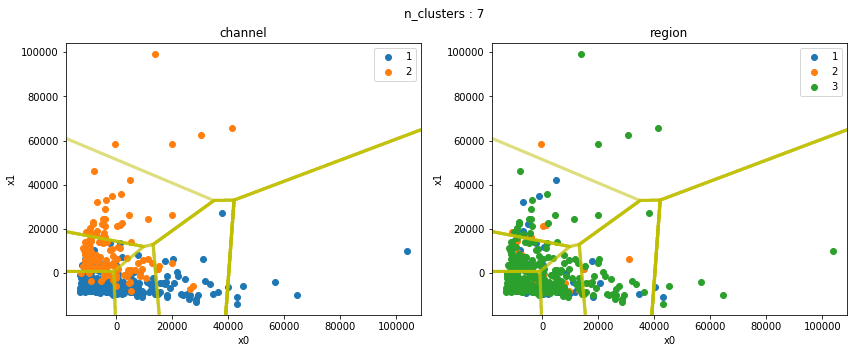

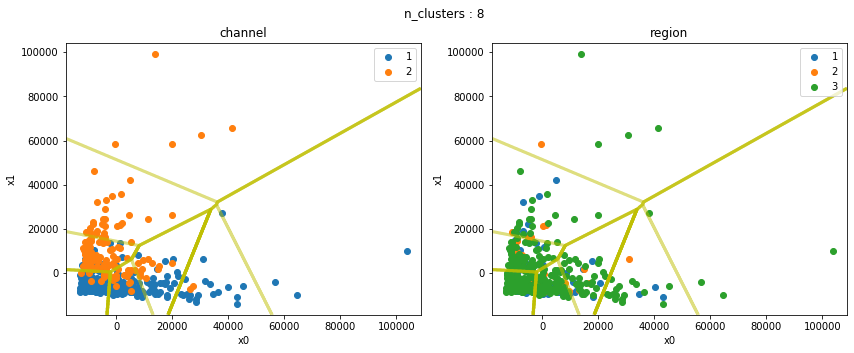

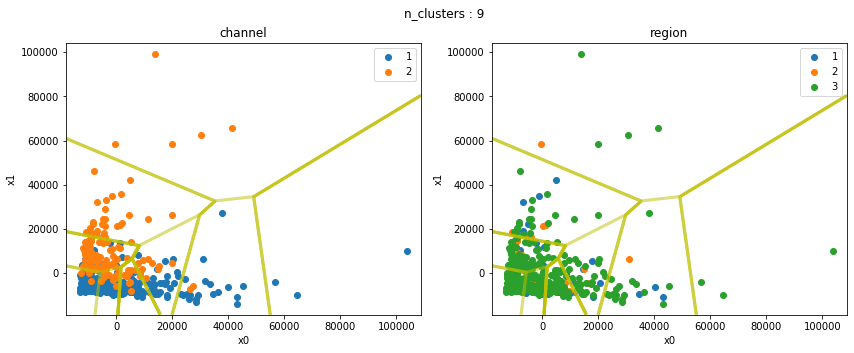

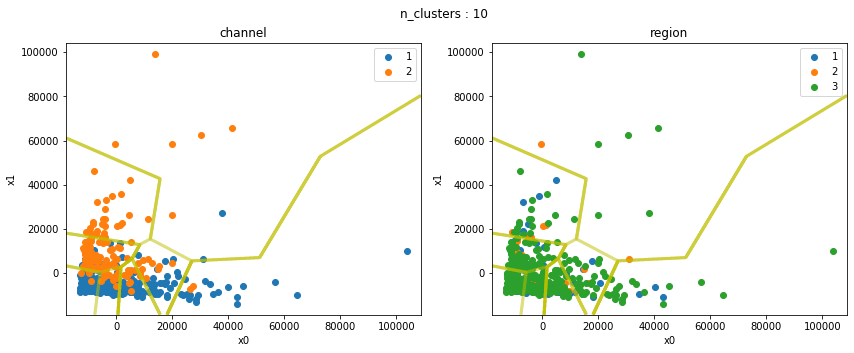

In [44]:
for n_clusters in range(2, 11):
    fig = plt.figure(figsize=(14, 5))
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1)
        # 既知のグループをプロット
        for label in np.unique(group_label[i]):
            label_index = np.where(group_label[i] == label)[0]
            ax.scatter(data_pca[label_index, 0], data_pca[label_index, 1], label=label)

        # クラスタk = 3の分布を表示
        scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                             tol=1e-4, verbose=False, random_state=0)
        scratch.fit(data_pca)
        mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
        # plt.contourf(mesh_f0, mesh_f1, mesh_pred, alpha=0.3,  cmap=ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_clusters]))
        ax.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
        ax.legend()
        ax.set_xlabel('x0')
        ax.set_ylabel('x1')
        ax.set_title(title[i])
    fig.suptitle('n_clusters : {}'.format(n_clusters))
    plt.show()

- クラスタ数を増加させても複雑性が増しそうなので、クラスタ数kは3のままにする

## 【問題12】卸売業者にとって有益な情報
卸売業者にとって有益な情報を探し出し文章にまとめてください。

**《ヒント》**

前処理を行う前のデータを使い、各クラスタの要約統計量を見るなどしてみましょう。また、PCAで次元削減したデータに対してK-meansを使用しましたが、6個の特徴量をそのまま使ったり、一部の特徴量のみを使ったりということも試してみてください。既知のグループとの比較結果も参考にしてください。

条件ごとにデータを見る際にはPandasの`groupby`が便利です。

[pandas.DataFrame.groupby — pandas 0.23.4 documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html)

In [45]:
# クラスタk = 3
scratch = ScratchKMeans(n_clusters=3, n_init=10, max_iter=300, tol=1e-4, verbose=False, random_state=0)
scratch.fit(data_pca)

In [46]:
# データフレームにクラスタ情報を追加
df['cluster'] = scratch.cluster_labels
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,cluster
0,2,3,12669,9656,7561,214,2674,1338,34112,2
1,2,3,7057,9810,9568,1762,3293,1776,33266,2
2,2,3,6353,8808,7684,2405,3516,7844,36610,2
3,1,3,13265,1196,4221,6404,507,1788,27381,2
4,2,3,22615,5410,7198,3915,1777,5185,46100,1


In [47]:
# クラスタ毎の要約統計量
for i in range(3):
    print('要約統計量　cluster : {}'.format(i))
    display(df[df['cluster'] == i].describe())

要約統計量　cluster : 0


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,cluster
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.0
mean,1.960784,2.450980,8027.411765,18375.921569,27342.549020,2014.313725,12314.607843,2233.254902,70308.058824,0.0
std,0.196039,0.807805,9035.038851,12883.867652,14464.558588,2052.296309,7979.880318,2663.207043,37293.043069,0.0
min,1.000000,1.000000,85.000000,3737.000000,13567.000000,33.000000,282.000000,3.000000,35425.000000,0.0
25%,2.000000,2.000000,1839.000000,11094.000000,19632.500000,796.000000,7389.000000,723.500000,48291.000000,0.0
50%,2.000000,3.000000,5531.000000,14399.000000,22294.000000,1274.000000,9959.000000,1423.000000,56978.000000,0.0
75%,2.000000,3.000000,10953.000000,21951.000000,28953.500000,2735.000000,14538.000000,2716.500000,74625.500000,0.0
max,2.000000,3.000000,44466.000000,73498.000000,92780.000000,10155.000000,40827.000000,16523.000000,199891.000000,0.0


要約統計量　cluster : 1


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,cluster
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.0
mean,1.133333,2.566667,35941.400000,6044.450000,6288.616667,6713.966667,1039.666667,3049.466667,59077.566667,1.0
std,0.342803,0.789049,15234.899532,7055.554173,4629.034083,9555.164909,1302.215019,6355.491280,30260.418702,0.0
min,1.000000,1.000000,22096.000000,286.000000,471.000000,127.000000,10.000000,3.000000,28372.000000,1.0
25%,1.000000,2.750000,26294.250000,2054.250000,2575.500000,1364.750000,272.750000,949.500000,44745.750000,1.0
50%,1.000000,3.000000,30818.000000,3954.500000,5058.500000,3662.000000,511.500000,1535.500000,50137.500000,1.0
75%,1.000000,3.000000,40370.750000,7160.000000,8259.750000,8871.000000,1116.500000,2880.250000,63436.750000,1.0
max,2.000000,3.000000,112151.000000,43950.000000,20170.000000,60869.000000,5058.000000,47943.000000,190169.000000,1.0


要約統計量　cluster : 2


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,cluster
count,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.0
mean,1.258359,2.553191,8249.996960,3800.966565,5248.556231,2571.677812,1755.112462,1137.018237,22763.328267,2.0
std,0.438399,0.767716,6203.295447,3167.764469,4338.746265,3409.848141,2164.321110,1281.958907,10351.578770,0.0
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000,904.000000,2.0
25%,1.000000,2.000000,2861.000000,1275.000000,2000.000000,660.000000,232.000000,361.000000,15284.000000,2.0
50%,1.000000,3.000000,7149.000000,2820.000000,3444.000000,1389.000000,637.000000,772.000000,22394.000000,2.0
75%,2.000000,3.000000,12377.000000,5758.000000,7684.000000,3141.000000,2894.000000,1542.000000,29804.000000,2.0
max,2.000000,3.000000,22686.000000,18664.000000,22272.000000,35009.000000,10069.000000,14472.000000,64617.000000,2.0


- 要約統計量を図示するために、クラスタ毎に箱ひげ図, バイオリン図を確認

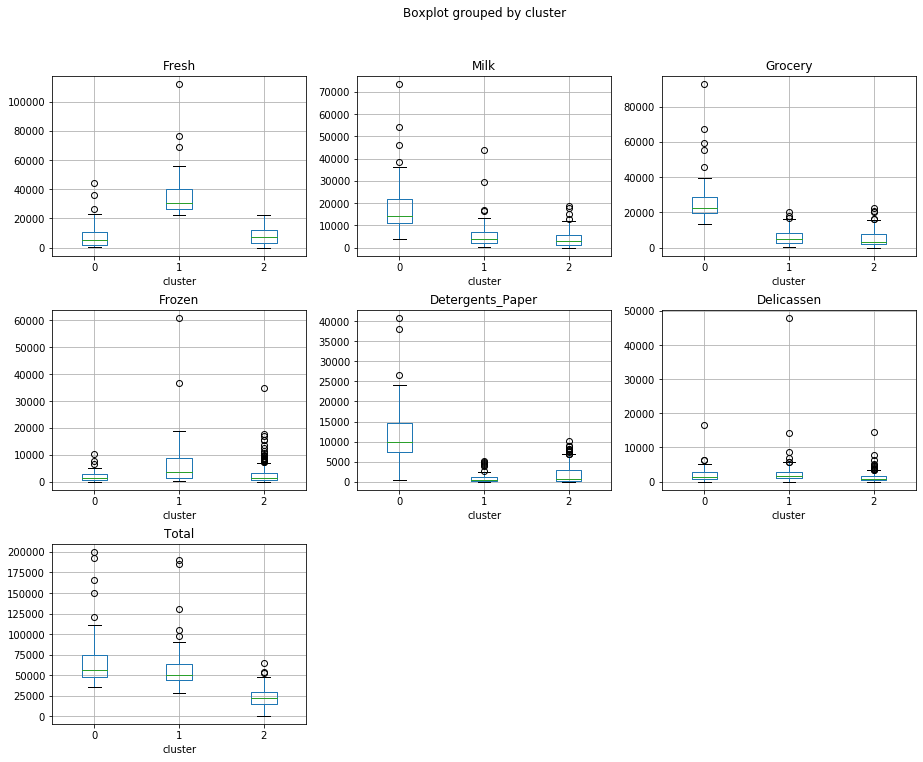

In [48]:
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    # sns.boxplot(data=df, x='cluster', y=columns[i], ax=ax)
    df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

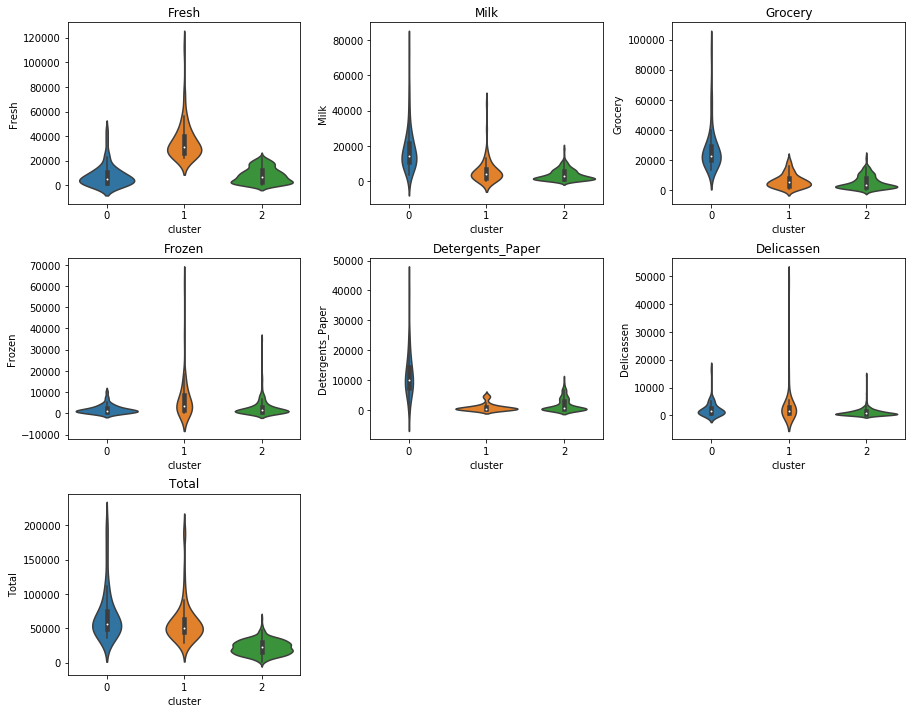

In [49]:
import seaborn as sns
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df, x='cluster', y=columns[i], ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

- クラスタ0は'Fresh', 'Frozen'の大口顧客が集まっている傾向
- クラスタ2は'Milk', 'Grocery', 'Detergents_Pater'の大口顧客が集まっている傾向であることが伺える

- 既存のグループも加味した分布も確認してみる

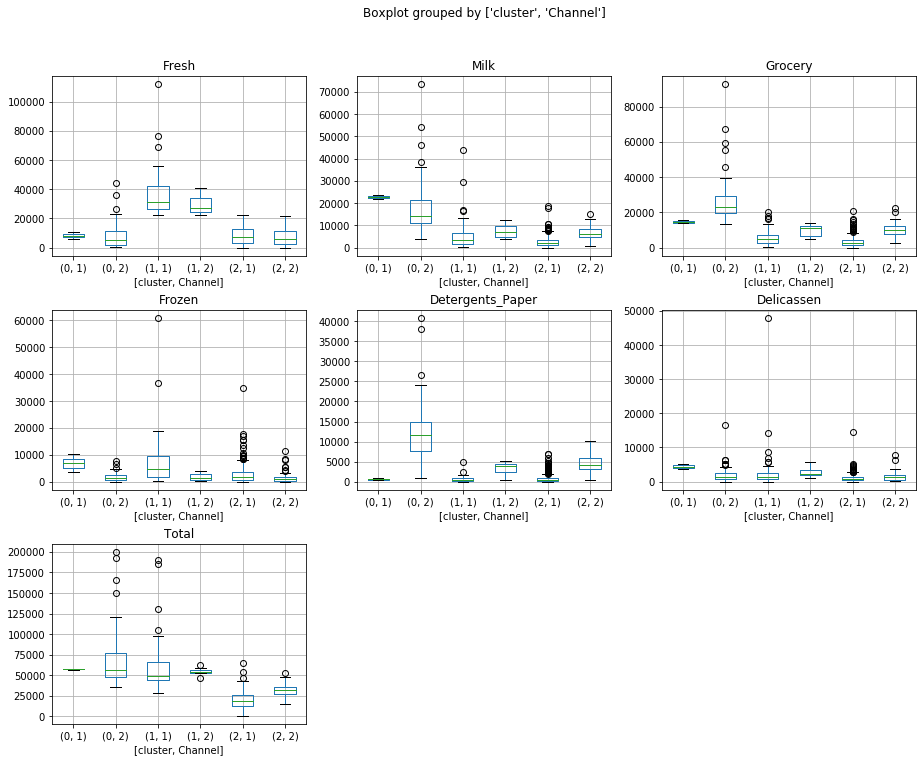

In [50]:
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    df.boxplot(column=columns[i], by=['cluster', 'Channel'], ax=ax)
    ax.set_title(columns[i])
plt.show()

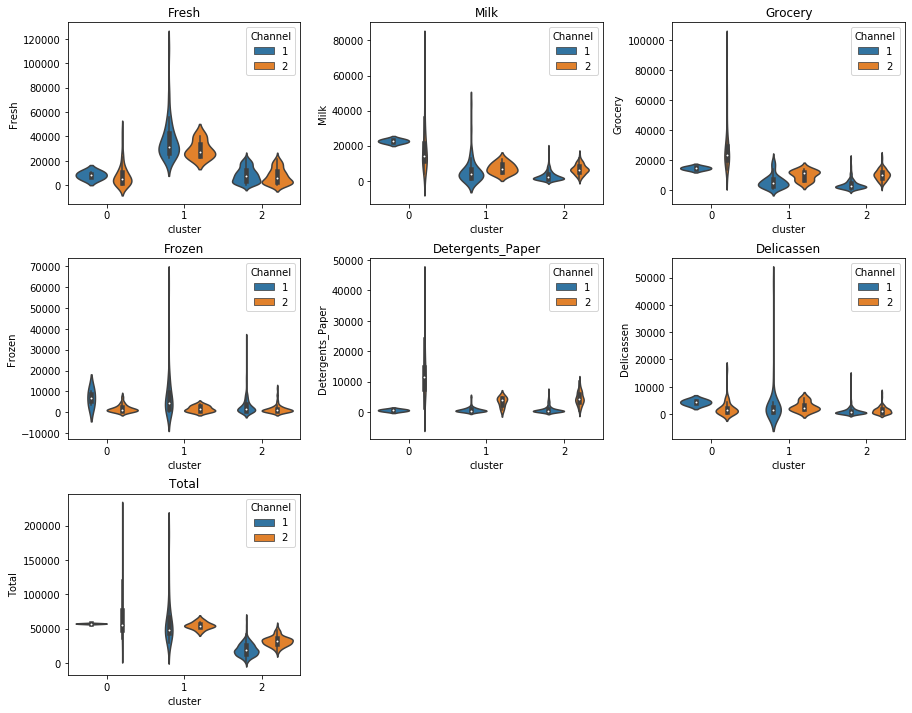

In [51]:
import seaborn as sns
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df, x='cluster', y=columns[i], hue='Channel', ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

- クラスタ0は'Fresh', 'Frozen'の大口顧客が集まっている傾向
    - 'Frozen'に関して、クラスタより、Channelの影響が大きく見てとれ、どのクラスタにおいてもChannel1に大口顧客が集まっている傾向
- クラスタ2は'Milk', 'Grocery', 'Detergents_Pater'の大口顧客が集まっている傾向であることが伺える
    - 'Milk'に関して、クラスタ２、Channel1に固定的な大口顧客がいる
    - 'Detergents_Paper'に関して、クラスタより、Channelの影響が大きく見てとれ、どのクラスタにおいてもChannel2に大口顧客が集まっている傾向

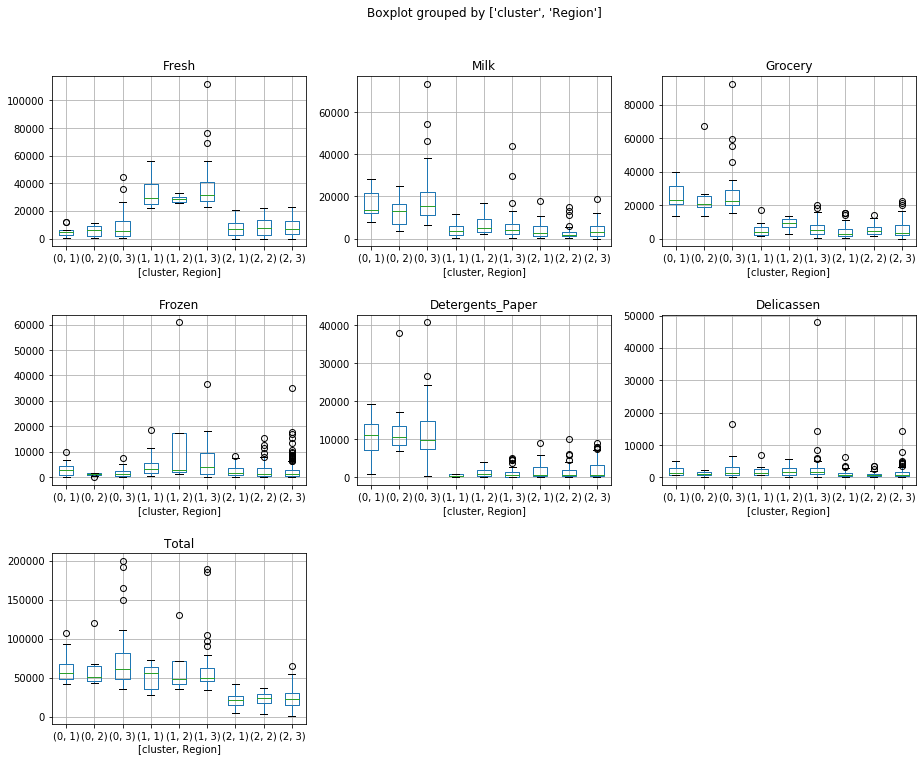

In [52]:
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    df.boxplot(column=columns[i], by=['cluster', 'Region'], ax=ax)
    ax.set_title(columns[i])
plt.show()

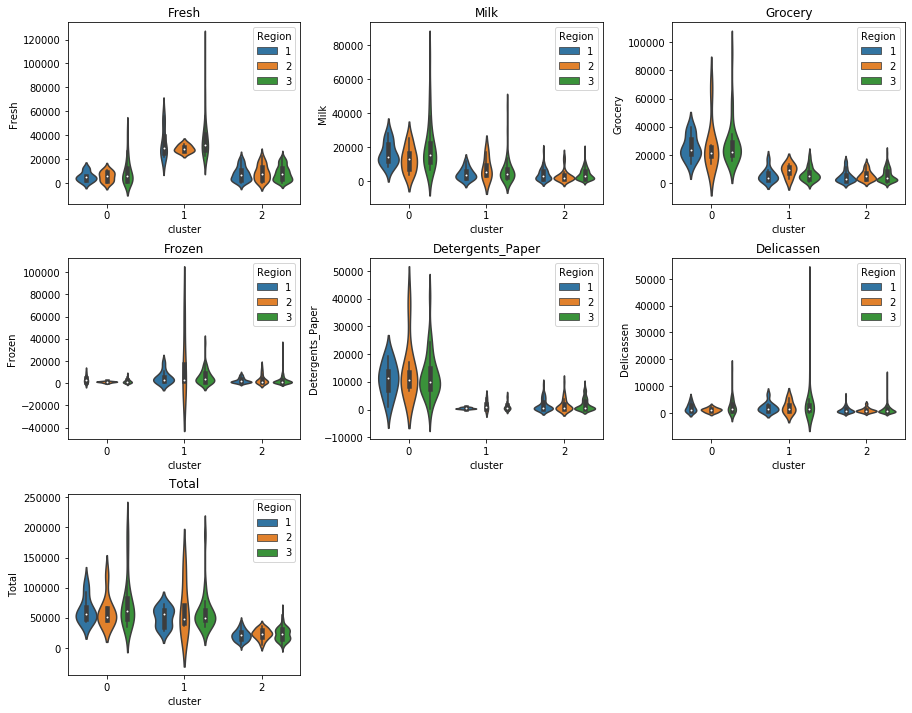

In [53]:
import seaborn as sns
columns = df.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df, x='cluster', y=columns[i], hue='Region', ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

- 外れ値の影響をのぞき、Region間でクラスタ内の大きな変動は見受けられない

- 商品毎の大口顧客の分類において、Channelの影響が一定見受けられた
- Channel毎にクラスタ分類を再度行ってみる

#### Channel1

[0.74810135 0.88806795 0.95613662 0.98025582 0.99719113 1.        ]


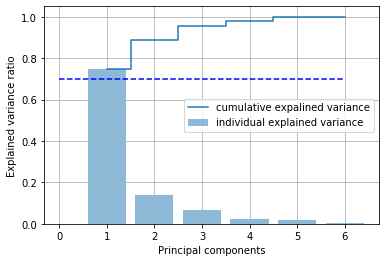

In [54]:
# Channel1
df_channel1 = df[df['Channel']==1].drop('cluster', axis=1)
data = df_channel1.iloc[:, 2:-1].values
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

- Channel1のデータを二次元まで削減して、クラスタにわけてみる

In [55]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
# ２次元まで削減したデータ
data_pca = pca.transform(data)

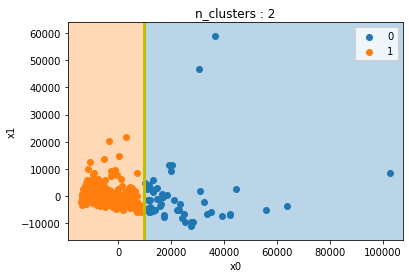

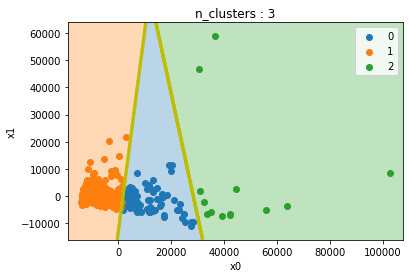

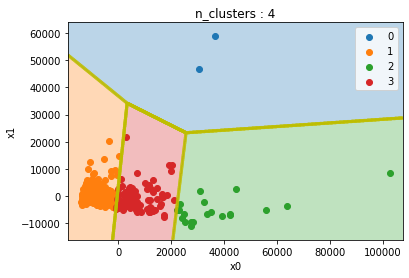

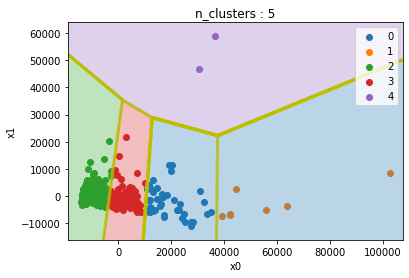

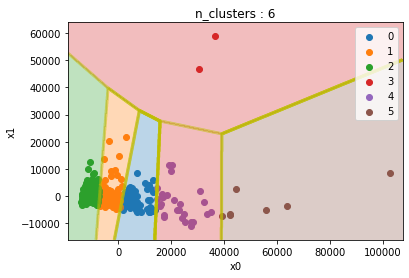

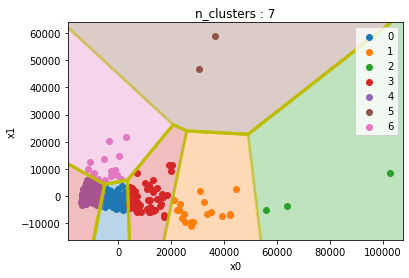

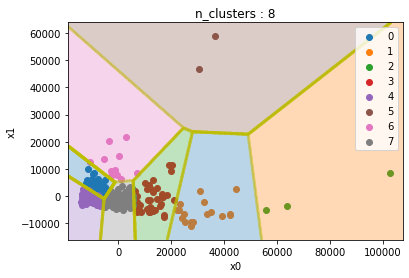

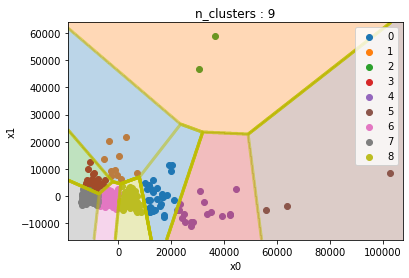

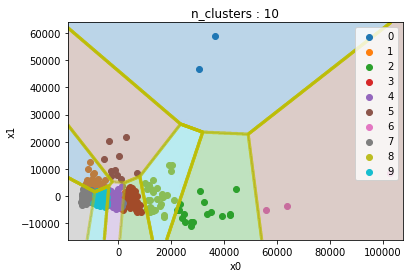

In [56]:
# 領域の図
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(data_pca[:,0])-5000,
                                          np.max(data_pca[:,0])+5000, 100),
                                np.arange(np.min(data_pca[:,1])-5000,
                                          np.max(data_pca[:,1])+5000, 100))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

for n_clusters in range(2, 11):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                         tol=1e-4, verbose=False, random_state=0)
    scratch.fit(data_pca)
    mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
    for i in range(n_clusters):
        plot_index = np.where(scratch.cluster_labels == i)[0]
        plt.scatter(data_pca[plot_index, 0], data_pca[plot_index, 1], label=i)
    plt.contourf(mesh_f0, mesh_f1, mesh_pred, alpha=0.3,  cmap=ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_clusters]))
    plt.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.legend()
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

- 大口顧客の分類において、xの絶対量の大きさで判断できるため、n_clusters : 3で分類

In [57]:
# クラスタk = 3
scratch = ScratchKMeans(n_clusters=3, n_init=10, max_iter=300, tol=1e-4, verbose=False, random_state=0)
scratch.fit(data_pca)
# データフレームにクラスタ情報を追加
df_channel1['cluster'] = scratch.cluster_labels

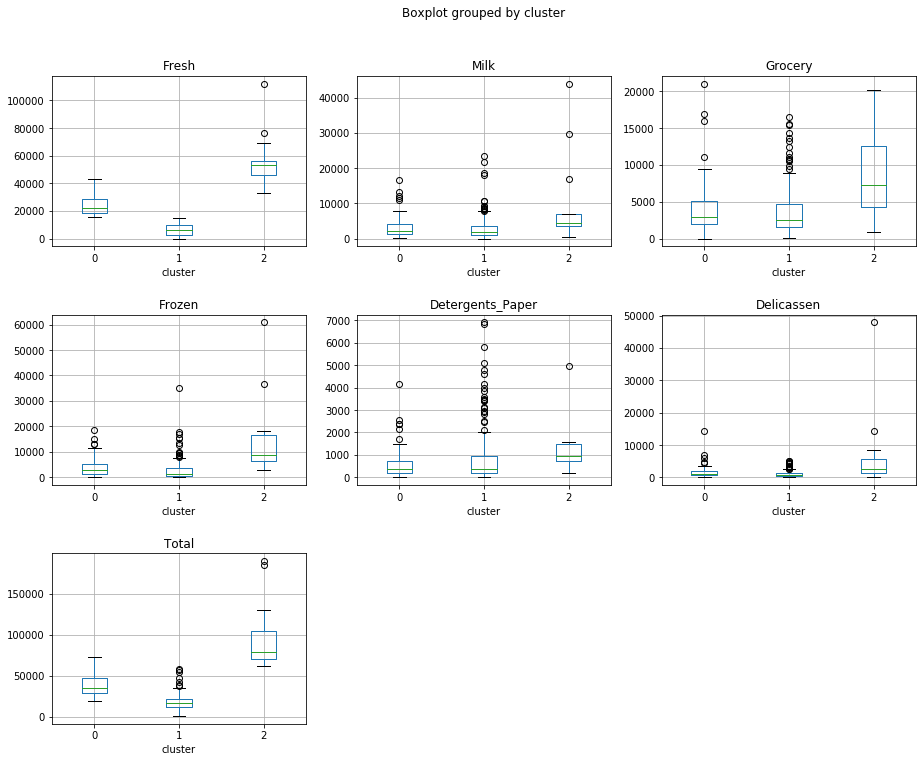

In [58]:
columns = df_channel1.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    df_channel1.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

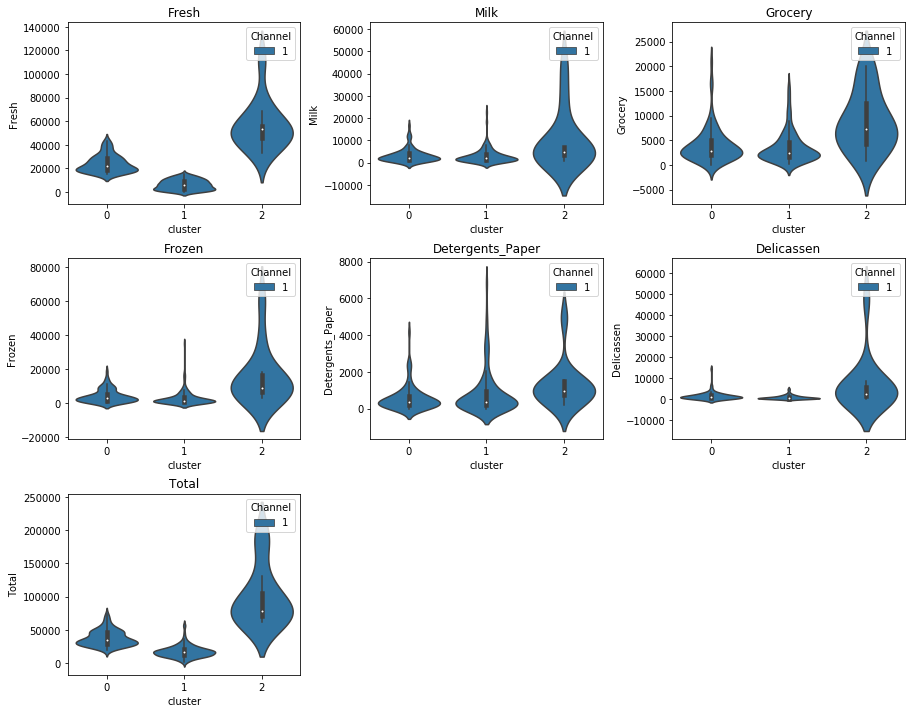

In [59]:
import seaborn as sns
columns = df_channel1.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df_channel1, x='cluster', y=columns[i], hue='Channel', ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

#### Channel2

[0.64636552 0.87027636 0.97121754 0.98457525 0.99388154 1.        ]


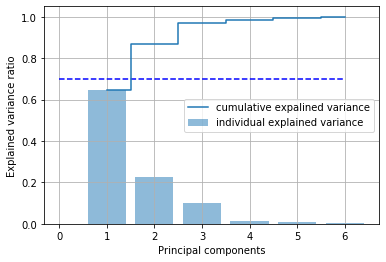

In [60]:
# Channel2
df_channel2 = df[df['Channel']==2].drop('cluster', axis=1)
data = df_channel2.iloc[:, 2:-1].values
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=None)
pca = pca.fit(data)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

- Channel2のデータを二次元まで削減して、クラスタにわけてみる

In [61]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
# ２次元まで削減したデータ
data_pca = pca.transform(data)

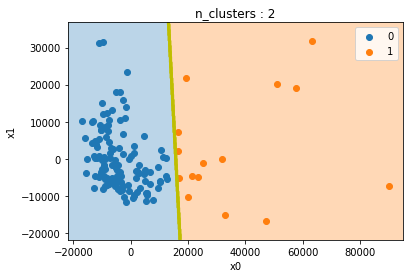

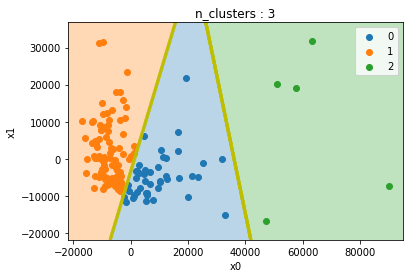

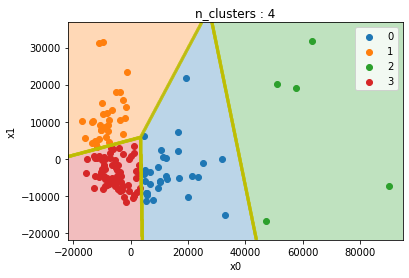

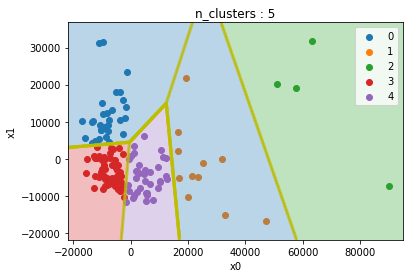

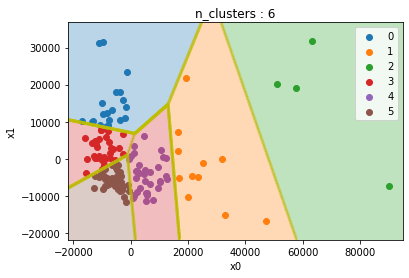

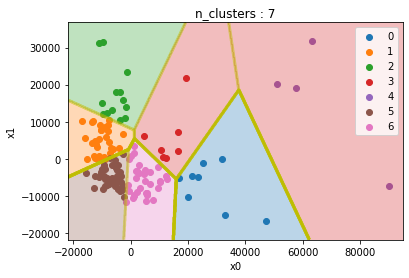

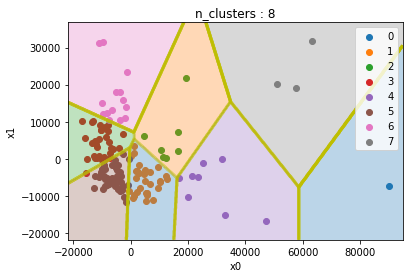

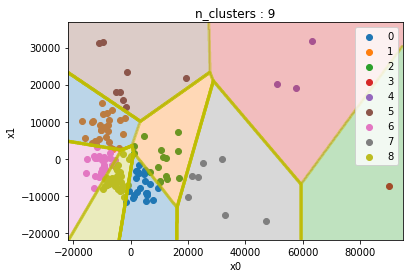

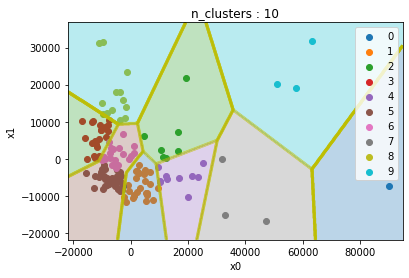

In [62]:
# 領域の図
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(data_pca[:,0])-5000,
                                          np.max(data_pca[:,0])+5000, 100),
                                np.arange(np.min(data_pca[:,1])-5000,
                                          np.max(data_pca[:,1])+5000, 100))
mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]

for n_clusters in range(2, 11):
    scratch = ScratchKMeans(n_clusters=n_clusters, n_init=10, max_iter=300,
                         tol=1e-4, verbose=False, random_state=0)
    scratch.fit(data_pca)
    mesh_pred = scratch.predict(mesh).reshape(mesh_f0.shape)
    for i in range(n_clusters):
        plot_index = np.where(scratch.cluster_labels == i)[0]
        plt.scatter(data_pca[plot_index, 0], data_pca[plot_index, 1], label=i)
    plt.contourf(mesh_f0, mesh_f1, mesh_pred, alpha=0.3,  cmap=ListedColormap(plt.rcParams['axes.prop_cycle'].by_key()['color'][:n_clusters]))
    plt.contour(mesh_f0, mesh_f1, mesh_pred, colors='y', linewidths=3, alpha=0.5)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.legend()
    plt.title('n_clusters : {}'.format(n_clusters))
    plt.show()

- 大口顧客の分類において、xの絶対量の大きさで判断できるため、n_clusters : 4で分類

In [63]:
# クラスタk = 4
scratch = ScratchKMeans(n_clusters=4, n_init=10, max_iter=300, tol=1e-4, verbose=False, random_state=0)
scratch.fit(data_pca)
# データフレームにクラスタ情報を追加　クラスタの番号は3から
df_channel2['cluster'] = scratch.cluster_labels+3

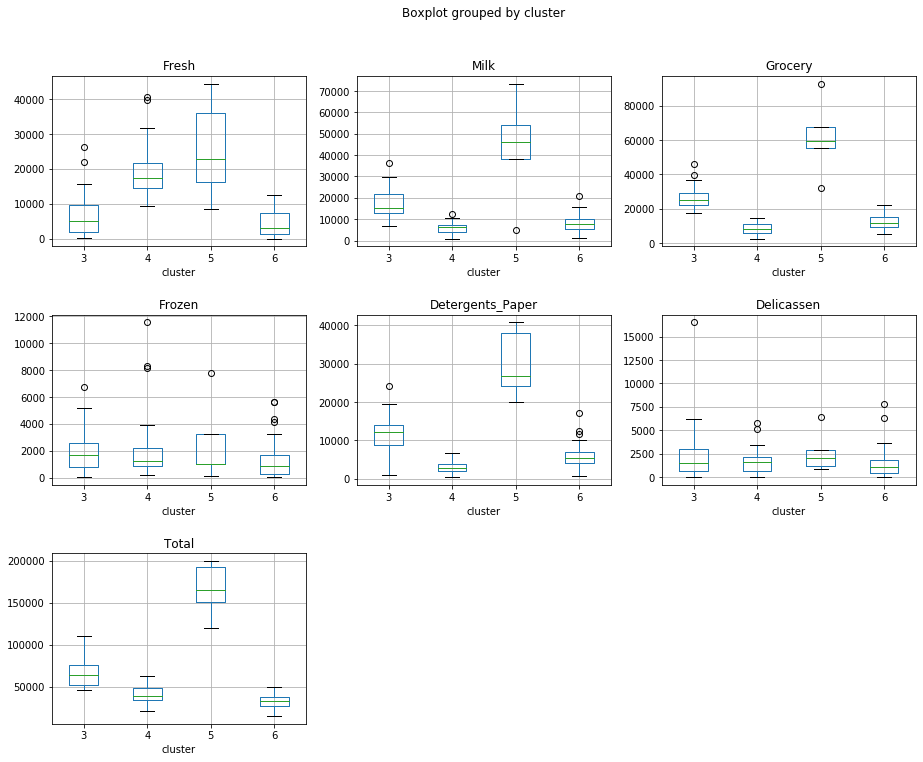

In [64]:
columns = df_channel2.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    df_channel2.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

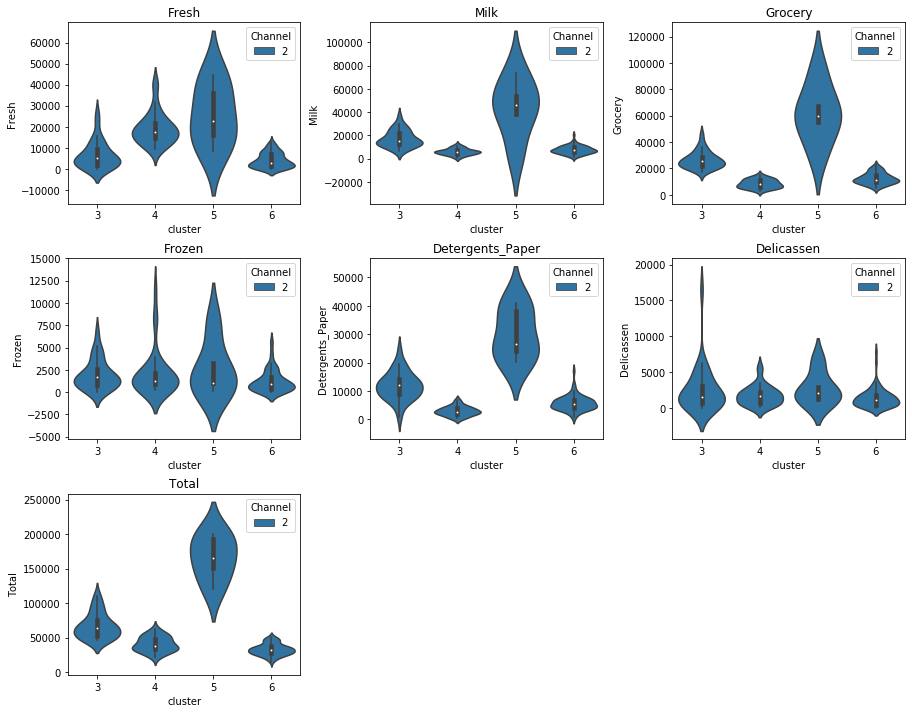

In [65]:
import seaborn as sns
columns = df_channel2.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df_channel2, x='cluster', y=columns[i], hue='Channel', ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

### Merge (Channel1, Channel2)

In [66]:
# df_channel1 と　df_channel2　を結合
df_concat = pd.concat([df_channel1, df_channel2], axis=0)

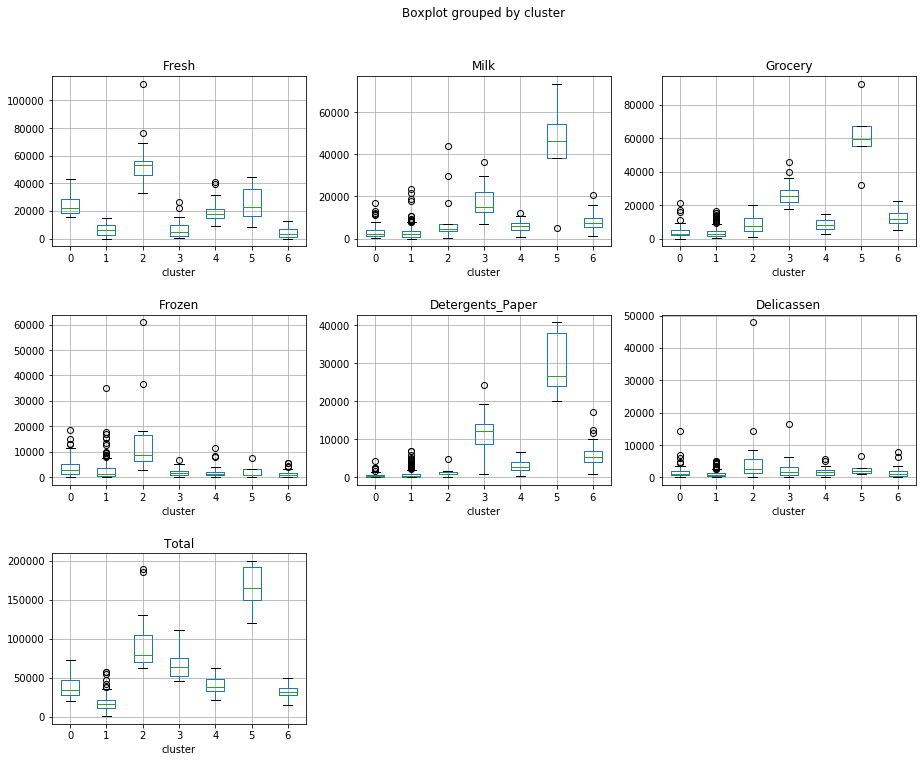

In [67]:
columns = df_concat.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    df_concat.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

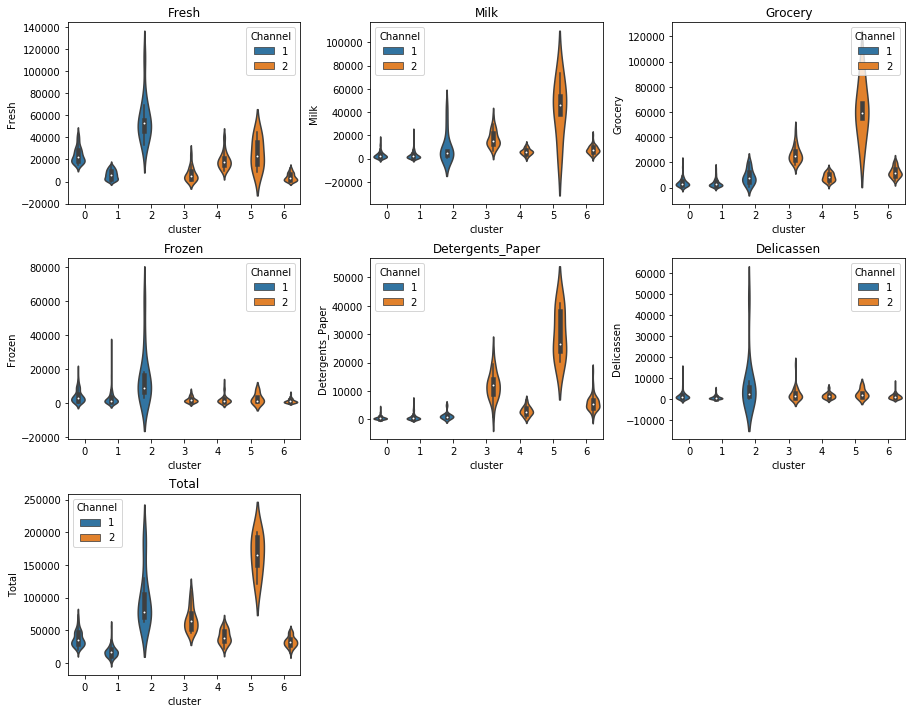

In [68]:
import seaborn as sns
columns = df_concat.columns[2:-1]
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(len(columns)):
    ax = fig.add_subplot(3, 3, i+1)
    sns.violinplot(data=df_concat, x='cluster', y=columns[i], hue='Channel', ax=ax)
    # df.boxplot(column=columns[i], by='cluster', ax=ax)
    ax.set_title(columns[i])
plt.show()

- まとめ
    - Channel毎にクラスタ分類を行い、Channel1は3つ、Channel2は4つのクラスタ分割した
    - Totalでみると、Channel1はcluster2, Channel2はcluster5　が購入金額の平均が高く、分布も多く存在している
    - また、cluster2は'Fresh', 'Frozen', cluster5は'Milk, 'Grocery', 'Detergents_Paper'の購入金額が大きいことがわかるので、その商品の販売戦略をたてる上での有用な情報となり得る

## 他の非階層クラスタリング手法

## 【問題13】（アドバンス課題）他の手法の調査
今回扱ったK-means以外に非階層クラスタリングで有名な手法としては **DBSCAN** 、
PCA以外に次元削減手法で有名な手法としては **t-SNE** や **LLE** があります。

- DBSCANのメリット・デメリット
- t-SNE、LLEのメリット・デメリット

について記述してください。

### DBSCAN
- Density Based Spatial Clustering of Applications with Noise

- メリット
    - k-meansと異なり、最初にクラスタ数を決める必要がない
    - クラスタが球状であることを前提とせず、歪んだクラスタでも分類できる
    - 外れ値、ノイズを分離できる
- デメリット
    - パラメーター($\omega$と$minPts$)の調整が難しい
    - 計算量が高い

### t-SNE, LLE
- t-distributed Stochastic Neightor Embedding
- Locally Linear Embedding

- PCA(主成分分析)とかMDS(多次元尺度構成法)の線形変換系手法には以下の問題があるため生まれた
    - 高次元空間上で非線形構造を持っているデータに対しては適切な低次元表現が得られない
    - 「類似するものを近くに配置する」ことよりも「類似しないものを遠くに配置する」ことを優先するようアルゴリズムが働く
    
- メリット
    - 線形では表現できない関係も学習して次元削減を行える
    - 可視化に特化しており、PCAなどと比較してより複雑なデータでも有効に働きやすい
- デメリット
    - 解析的に解けないため、計算に時間がかかる

## 【問題14】（アドバンス課題）t-SNEとDBSCANの利用
Wholesale customersのデータに対して、PCAではなく、 **t-SNE** を用いて次元削減をしてください。さらにK-meansではなく、 **DBSCAN** を用いてクラスタリングしてください。

そのクラスタリング結果をPCA+kmeansの場合の結果と比較してみましょう。実装にはscikit-learnを用いてください。

[sklearn.manifold.TSNE — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[sklearn.cluster.DBSCAN — scikit-learn 0.20.2 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

In [69]:
df = pd.read_csv(url)
data = df.iloc[:, 2:].values
data.shape

(440, 6)

In [70]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, early_exaggeration=12.0,
            learning_rate=200.0, n_iter=1000, n_iter_without_progress=300,
            min_grad_norm=1e-07, metric='euclidean', init='random', verbose=0,
            random_state=0, method='barnes_hut', angle=0.5, n_jobs=None)
data_embedded = tsne.fit_transform(data)

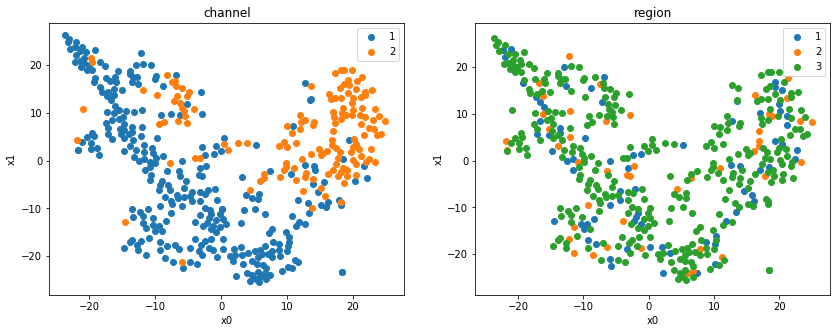

In [71]:
# Channel, Region　毎に分布を確認
channel = df.iloc[:, 0].values
region = df.iloc[:, 1].values
group_label = [channel, region]
title = ['channel', 'region']
fig = plt.figure(figsize=(14, 5))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    # 既知のグループをプロット
    for label in np.unique(group_label[i]):
        label_index = np.where(group_label[i] == label)[0]
        ax.scatter(data_embedded[label_index, 0], data_embedded[label_index, 1], label=label)
    ax.legend()
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(title[i])
plt.show()

In [72]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2.3, min_samples=5, metric='euclidean',
                metric_params=None, algorithm='auto', leaf_size=30,
                p=None, n_jobs=None)
dbscan.fit(data_embedded)
dbscan_labels = dbscan.labels_
np.unique(dbscan_labels, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6]),
 array([ 18,  16, 114,   8, 239,  29,  13,   3]))

In [73]:
# PCAで次元削減
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data)
data_pca = pca.transform(data)
# kmeansでクラスタリング
from sklearn.cluster import k_means
kmeans_cetroid, kmeans_label, kmeans_inertia, best_n_iter = k_means(data_pca, n_clusters=3, random_state=0,return_n_iter=True)

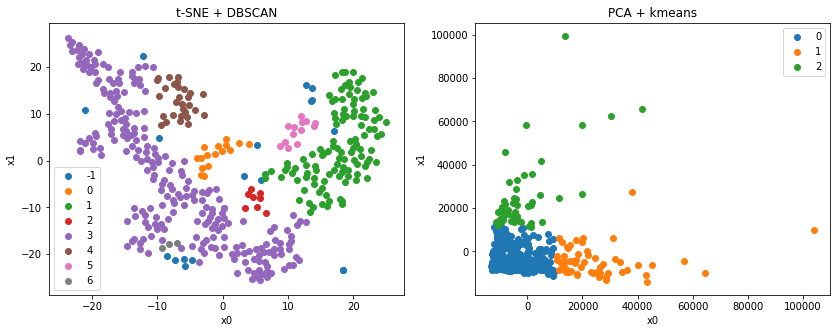

In [74]:
# 分類毎に分布を確認
group_label = [dbscan_labels, kmeans_label]
data_lst = [data_embedded, data_pca]
title = ['t-SNE + DBSCAN', 'PCA + kmeans']
fig = plt.figure(figsize=(14, 5))
for i in range(2):
    ax = fig.add_subplot(1, 2, i+1)
    # 既知のグループをプロット
    for label in np.unique(group_label[i]):
        label_index = np.where(group_label[i] == label)[0]
        ax.scatter(data_lst[i][label_index, 0], data_lst[i][label_index, 1], label=label)
    ax.legend()
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_title(title[i])
plt.show()

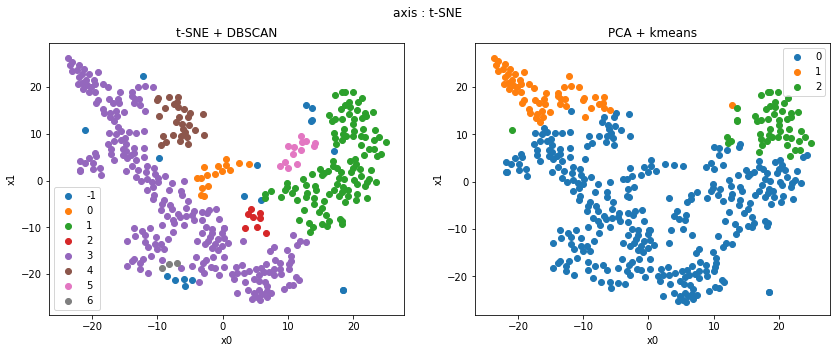

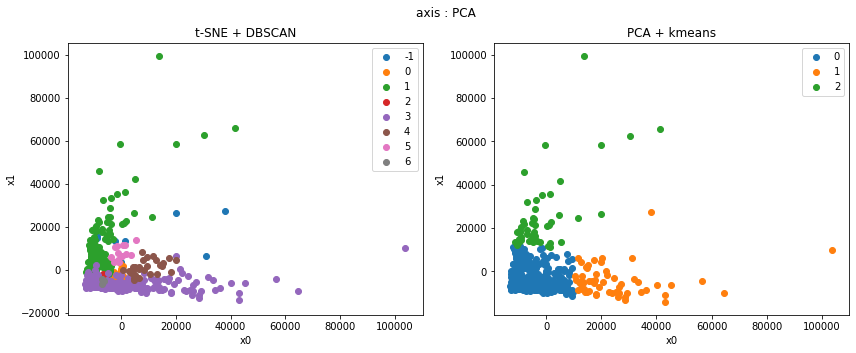

In [75]:
# 軸を揃えて図示してみる
group_label = [dbscan_labels, kmeans_label]
data_lst = [data_embedded, data_pca]
title = ['t-SNE + DBSCAN', 'PCA + kmeans']
fig_title = ['t-SNE', 'PCA']
for j in range(2):
    fig = plt.figure(figsize=(14, 5))
    for i in range(2):
        ax = fig.add_subplot(1, 2, i+1)
        # 既知のグループをプロット
        for label in np.unique(group_label[i]):
            label_index = np.where(group_label[i] == label)[0]
            ax.scatter(data_lst[j][label_index, 0], data_lst[j][label_index, 1], label=label)
        ax.legend()
        ax.set_xlabel('x0')
        ax.set_ylabel('x1')
        ax.set_title(title[i])
    fig.suptitle('axis : {}'.format(fig_title[j]))
    plt.show()

**《パラメーターチューニング》**

これらはK-meansやPCAに比べパラメーターチューニングが難しい手法です。scikit-learnのドキュメントと共に論文も参考にしながらパラメータの意味を確認することも大切になります。

[t-SNEの論文](http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

[DBSCANの論文](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf)